# Bike Sharing Case Study | Linear Regression Model


#### License

Use of this dataset in publications must be cited to the following publication:

[1] Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

@article{
  year={2013},
  issn={2192-6352},
  journal={Progress in Artificial Intelligence},
  doi={10.1007/s13748-013-0040-3},
  title={Event labeling combining ensemble detectors and background knowledge},
  url={http://dx.doi.org/10.1007/s13748-013-0040-3},
  publisher={Springer Berlin Heidelberg},
  keywords={Event labeling; Event detection; Ensemble learning; Background knowledge},
  author={Fanaee-T, Hadi and Gama, Joao},
  pages={1-15}
}

Contact

For further information about this dataset please contact Hadi Fanaee-T (hadi.fanaee@fe.up.pt)


### 1. **Introduction**
   - **Objective:** 
   The goal of this analysis is to build a multiple linear regression model to predict bike demand and understand the significant factors influencing it. By analyzing the dataset, we aim to derive insights that can help BoomBikes optimize their operations and meet customer demand efficiently.


   - **Business Understanding:** BoomBikes is a bike-sharing company that seeks to understand the patterns in bike usage to optimize their fleet management. Predicting bike demand accurately is crucial for ensuring that bikes are available when and where customers need them. This analysis will help identify the key factors affecting bike demand and enable data-driven decision-making for inventory management, marketing strategies, and operational improvements.


### 2. **Data Understanding**
   - **Load the Data:** Load the dataset (`day.csv`) and display the first few rows to understand its structure.
   - **Data Dictionary:** Below is a brief overview of the columns present in the dataset:

         | Column Name   | Description                                                                     |
         |---------------|---------------------------------------------------------------------------------|
         | instant       | Record index                                                                    |
         | dteday        | Date                                                                            |
         | season        | Season (1: winter, 2: spring, 3: summer, 4: fall)                               |
         | yr            | Year (0: 2018, 1: 2019)                                                         |
         | mnth          | Month (1 to 12)                                                                 |
         | holiday       | Whether the day is a holiday (0: No, 1: Yes)                                    |
         | weekday       | Day of the week (0 to 6)                                                        |
         | workingday    | If the day is neither a weekend nor a holiday (1/0)                             |
         | weathersit    | Weather situation (1: clear, 2: cloudy, 3: light rain/snow), 4: Heavy rain/snow |
         | temp          | temperature in Celsius                                                          |
         | atemp         | feeling temperature in Celsius                                                  |
         | hum           | humidity                                                                        |
         | windspeed     | wind speed                                                                      |
         | casual        | Count of casual users                                                           |
         | registered    | Count of registered users                                                       |
         | cnt           | Count of total rental bikes                                                     |

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid", palette='pastel')

In [2]:
import pandas as pd
from scipy.stats import skew, kurtosis


def ct_x_by_vol(data: pd.DataFrame, row : str, volume : str) -> pd.DataFrame:
    """
    ct_x_by_vol
    -----------

    Creates row x sum of volume
    
    data    : Pandas dataframe
    row     : variable on the side
    volume  : volume variable

    Return  :
        Pandas dataframe for pivot 
    """

    # print (f'--------{row} x {volume}----------')
    grouped_data = data.groupby(row, observed=False)[
        volume].sum().reset_index()
    total_cnt = grouped_data[volume].sum()
    grouped_data['percentage'] = (grouped_data[volume] / total_cnt) * 100
    pivot_table = pd.pivot_table(
        data, values=volume, index=row, aggfunc='sum', observed=False)
    pivot_table['percentage'] = (
        (pivot_table[volume] / pivot_table[volume].sum()) * 100).round(2)

    # print(pivot_table)
    # return grouped_data, pivot_table
    return pivot_table


def ct_x_by_y_by_vol(data: pd.DataFrame, row: str, col: str, volume: str):
    """
    ct_x_by_y_by_vol
    ----------------

    Creates row x col x sum of volume
    
    data    : Pandas dataframe
    row     : variable on the side
    col     : variable on the top
    volume  : volume variable

    Return  :
        Pandas dataframe for pivot 
    """
    
    # print(f'-------- {row} x {col} x {volume} --------')
    pivot_table = pd.pivot_table(
        data, values=volume, index=row, columns=col, aggfunc='sum', observed=False)
    total_volume = pivot_table.values.sum()
    pivot_table_percentage = (pivot_table / total_volume) * 100
    combined_table = pivot_table.copy()
    for col in pivot_table.columns:
        combined_table[f'{col}_percentage'] = pivot_table_percentage[col]

    combined_table = combined_table.round(2)

    # print(combined_table)
    return combined_table


def detailed_descriptive_categorical(data: pd.DataFrame) -> pd.DataFrame:
    """
    detailed_descriptive_categorical
    --------------------------------

    Returns useful summary stats for categorical variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """
    columns = data.select_dtypes(exclude=[
                                 'int8', 'int16', 'int32', 'int64', 'Int64', 'float16', 'float32', 'float64']).columns
    stats = pd.DataFrame(index=columns)
    stats['missing_values'] = data[columns].isna().sum()
    stats['unique_values'] = data[columns].nunique()
    stats['most_frequent'] = data[columns].mode().iloc[0]
    stats['frequency'] = data[columns].apply(
        lambda x: x.value_counts().iloc[0])
    stats['top_5_frequent'] = data[columns].apply(
        lambda x: x.value_counts().head(5).to_dict())
    return stats


def detailed_descriptive_numerical(data: pd.DataFrame) -> pd.DataFrame:
    """
    detailed_descriptive_numerical
    --------------------------------

    Returns useful summary stats for numerical variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """

    columns = data.select_dtypes(include=[
                                 'int8', 'int16', 'int32', 'int64', 'Int64', 'float16', 'float32', 'float64']).columns
    # columns = sorted(columns)
    stats = data[columns].describe().round(2).T
    stats['missing_values'] = data[columns].isna().sum()
    stats['skew'] = data[columns].skew()
    stats['kurtosis'] = data[columns].kurtosis()
    stats['mode'] = data[columns].mode().iloc[0]
    return stats


def cap_outliers_isolation_forest(data: pd.DataFrame, columns: list, contamination: float = 0.01) -> pd.DataFrame:
    """
    cap_outliers_isolation_forest
    -----------------------------

    Caps columns in data using Isolation Forest

    data    : Pandas dataframe
    columns : list of columns

    Returns :
        Capped dataframe
    
    """

    clf = IsolationForest(contamination=contamination, random_state=42)

    for column in columns:
        data['outlier_if'] = clf.fit_predict(data[[column]])

        non_outliers = data[data['outlier_if'] == 1][column]
        lower_bound = non_outliers.min()
        upper_bound = non_outliers.max()

        data[column] = np.where(data[column] < lower_bound,
                              lower_bound, data[column])
        data[column] = np.where(data[column] > upper_bound,
                              upper_bound, data[column])

        data = data.drop(columns=['outlier_if'])
        print(f'Capped outliers in {column}')

    return data


def plot_correlation_matrix(data: pd.DataFrame, columns: list) -> None:
    """
    plot_correlation_matrix
    -----------------------

    Print plot with correlation matrix using Pearson's R
    
    data    : Pandas dataframe
    columns : list of variables

    Returns :
        None  
    """
    corr_matrix = data[columns].corr(
        method='pearson',
        min_periods=1,
        numeric_only=True
    )

    # Plotting the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
                fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

    # My handy fuction to understanding outlier by various methods
  
def analyze_and_plot_outliers(df, column):
    """
    analyze_and_plot_outliers
    -------------------------

    Calculates Z score, IQR and IsolationForest score for each column and plots it using box plot overlayed with KDE and Strip plot.
    Takes special care to ensure X and Y scale align to allow visual comparision

    """

    print(f'---- {column} ----')

    # Copy dataframe as we are not yet trying to remove data
    df = pd.DataFrame(df[column], columns=[column]).copy(deep=True)

    if df[column].std() == 0:
        df['z_score'] = 0
    else:
        df['z_score'] = np.abs(zscore(df[column]))
    df['outlier_z'] = df['z_score'] > 3

    # IQR Method
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df['outlier_iqr'] = (df[column] < (Q1 - 1.5 * IQR)
                         ) | (df[column] > (Q3 + 1.5 * IQR))

    # Isolation Forest Method
    clf = IsolationForest(contamination=0.01, random_state=42)
    df['outlier_if'] = clf.fit_predict(df[[column]])
    df['outlier_if'] = df['outlier_if'] == -1

    plt.figure(figsize=(18, 6))

    outlier_methods = ['outlier_z', 'outlier_if', 'outlier_iqr']
    titles = ['Z-score Method', 'IsolationForest Method', 'IQR Method']

    for i, method in enumerate(outlier_methods):
        to_remove = df[df[method]][column].count()
        min_val = df[df[method] == False][column].min()
        med_val = df[df[method] == False][column].median()
        max_val = df[df[method] == False][column].max()

        plt.subplot(1, 3, i+1)
        sns.boxplot(data=df[df[method] == False], x=column, color='skyblue')
        # sns.swarmplot(data=df[df[method] == False], x=column, color='black', size=1)
        sns.stripplot(data=df[df[method] == False],
                      x=column, color='black', size=0.5, jitter=True)
        sns.kdeplot(data=df[df[method] == False],
                    x=column, color='orange', linewidth=2)
        plt.title(f'{column} ({titles[i]})')
        plt.xlabel(
            f'{column}\n(to_remove: {to_remove})\n(min: {min_val})\n(median: {med_val})\n(max: {max_val})')
        plt.ylabel('Density')
        plt.xscale('log')

    plt.tight_layout()
    plt.show()

In [3]:
# Load the dataset
data = pd.read_csv('https://raw.githubusercontent.com/mohiteamit/upGrad-LinearRegressionAssignment/main/day.csv')

# Display the first few rows of the dataset
data.head(n=10)

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   
5        6  06-01-2018       1   0     1        0        4           1   
6        7  07-01-2018       1   0     1        0        5           1   
7        8  08-01-2018       1   0     1        0        6           0   
8        9  09-01-2018       1   0     1        0        0           0   
9       10  10-01-2018       1   0     1        0        1           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   
5           1   8.378268  11.66045  51.8261   6.000868      88        1518   
6           2   8.057402  10.44195  49.8696  11.304642     148        1362   
7           2   6.765000   8.11270  53.5833  17.875868      68         891   
8           1   5.671653   5.80875  43.4167  24.250650      54         768   
9           1   6.184153   7.54440  48.2917  14.958889      41        1280   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
5  1606  
6  1510  
7   959  
8   822  
9  1321

### 3. **Data Cleaning**
   - **Missing Values:** Identify and handle any missing values appropriately.
   - **Invalid Values:** Check for and correct any invalid data entries.
   - **Formatting Issues:** Ensure consistent formatting for all columns.


    -----

    # We are dropping `dteday` column as it is incorrect and does not align with `holiday`, `weekday` and `workingday`.
    # We cannot correct this data based on dteday as volume `cnt` stops making sense in that case

    -----

In [4]:
# dropping dteday
data = data.drop(columns=['dteday'])

In [5]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values

instant       0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
# Checking for invalid data entries in categorical variables
unique_vals = {
    'season': data['season'].unique(),
    'yr': data['yr'].unique(),
    'mnth': data['mnth'].unique(),
    'holiday': data['holiday'].unique(),
    'weekday': data['weekday'].unique(),
    'workingday': data['workingday'].unique(),
    'weathersit': data['weathersit'].unique()
}
unique_vals

{'season': array([1, 2, 3, 4]),
 'yr': array([0, 1]),
 'mnth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'holiday': array([0, 1]),
 'weekday': array([6, 0, 1, 2, 3, 4, 5]),
 'workingday': array([0, 1]),
 'weathersit': array([2, 1, 3])}

In [7]:
# Checking range for numerical variables
detailed_descriptive_numerical(data)

count     mean      std    min      25%      50%      75%  \
instant     730.0   365.50   210.88   1.00   183.25   365.50   547.75   
season      730.0     2.50     1.11   1.00     2.00     3.00     3.00   
yr          730.0     0.50     0.50   0.00     0.00     0.50     1.00   
mnth        730.0     6.53     3.45   1.00     4.00     7.00    10.00   
holiday     730.0     0.03     0.17   0.00     0.00     0.00     0.00   
weekday     730.0     3.00     2.01   0.00     1.00     3.00     5.00   
workingday  730.0     0.68     0.47   0.00     0.00     1.00     1.00   
weathersit  730.0     1.39     0.54   1.00     1.00     1.00     2.00   
temp        730.0    20.32     7.51   2.42    13.81    20.47    26.88   
atemp       730.0    23.73     8.15   3.95    16.89    24.37    30.45   
hum         730.0    62.77    14.24   0.00    52.00    62.62    72.99   
windspeed   730.0    12.76     5.20   1.50     9.04    12.13    15.63   
casual      730.0   849.25   686.48   2.00   316.25   717.00  1096.50   
registered  730.0  3658.76  1559.76  20.00  2502.25  3664.50  4783.25   
cnt         730.0  4508.01  1936.01  22.00  3169.75  4548.50  5966.00   

                max  missing_values      skew   kurtosis         mode  
instant      730.00               0  0.000000  -1.200000     1.000000  
season         4.00               0 -0.002571  -1.341120     3.000000  
yr             1.00               0  0.000000  -2.005502     0.000000  
mnth          12.00               0 -0.010478  -1.207096     1.000000  
holiday        1.00               0  5.650014  30.004851     0.000000  
weekday        6.00               0  0.002745  -1.256688     0.000000  
workingday     1.00               0 -0.790992  -1.378114     1.000000  
weathersit     3.00               0  0.961855  -0.126895     1.000000  
temp          35.33               0 -0.057187  -1.118305    10.899153  
atemp         42.04               0 -0.133709  -0.984513    32.734400  
hum           97.25               0 -0.067476  -0.059830    61.333300  
windspeed     34.00               0  0.676314   0.405909     7.125450  
casual      3410.00               0  1.266328   1.321342   120.000000  
registered  6946.00               0  0.041211  -0.710250  1707.000000  
cnt         8714.00               0 -0.049581  -0.808080  1096.000000

In [8]:
# Checking data types
data.dtypes

instant         int64
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [9]:
# Converting necessary columns to categorical
categorical_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
data[categorical_columns] = data[categorical_columns].astype('category')

# Verifying the changes
data.dtypes

instant          int64
season        category
yr            category
mnth          category
holiday       category
weekday       category
workingday    category
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
cnt              int64
dtype: object

In [10]:
# Mapping categorical variables to their correct labels
data['season'] = data['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
data['weathersit'] = data['weathersit'].map({1: 'clear', 2: 'mist/cloud', 3: 'light rain/snow', 4: 'heavy rain/snow'})
data['weekday'] = data['weekday'].map({0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'})
data['mnth'] = data['mnth'].map({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})

# Display the first few rows to verify the changes
data.head()

instant  season yr     mnth holiday    weekday workingday  weathersit  \
0        1  spring  0  January       0   Saturday          0  mist/cloud   
1        2  spring  0  January       0     Sunday          0  mist/cloud   
2        3  spring  0  January       0     Monday          1       clear   
3        4  spring  0  January       0    Tuesday          1       clear   
4        5  spring  0  January       0  Wednesday          1       clear   

        temp     atemp      hum  windspeed  casual  registered   cnt  
0  14.110847  18.18125  80.5833  10.749882     331         654   985  
1  14.902598  17.68695  69.6087  16.652113     131         670   801  
2   8.050924   9.47025  43.7273  16.636703     120        1229  1349  
3   8.200000  10.60610  59.0435  10.739832     108        1454  1562  
4   9.305237  11.46350  43.6957  12.522300      82        1518  1600

### 4. **Exploratory Data Analysis (EDA)** 

In [11]:
detailed_descriptive_numerical(data)

count     mean      std    min      25%      50%      75%  \
instant     730.0   365.50   210.88   1.00   183.25   365.50   547.75   
temp        730.0    20.32     7.51   2.42    13.81    20.47    26.88   
atemp       730.0    23.73     8.15   3.95    16.89    24.37    30.45   
hum         730.0    62.77    14.24   0.00    52.00    62.62    72.99   
windspeed   730.0    12.76     5.20   1.50     9.04    12.13    15.63   
casual      730.0   849.25   686.48   2.00   316.25   717.00  1096.50   
registered  730.0  3658.76  1559.76  20.00  2502.25  3664.50  4783.25   
cnt         730.0  4508.01  1936.01  22.00  3169.75  4548.50  5966.00   

                max  missing_values      skew  kurtosis         mode  
instant      730.00               0  0.000000 -1.200000     1.000000  
temp          35.33               0 -0.057187 -1.118305    10.899153  
atemp         42.04               0 -0.133709 -0.984513    32.734400  
hum           97.25               0 -0.067476 -0.059830    61.333300  
windspeed     34.00               0  0.676314  0.405909     7.125450  
casual      3410.00               0  1.266328  1.321342   120.000000  
registered  6946.00               0  0.041211 -0.710250  1707.000000  
cnt         8714.00               0 -0.049581 -0.808080  1096.000000

In [12]:
detailed_descriptive_categorical(data)

missing_values  unique_values most_frequent  frequency  \
season                   0              4          fall        188   
yr                       0              2             0        365   
mnth                     0             12       January         62   
holiday                  0              2             0        709   
weekday                  0              7        Sunday        105   
workingday               0              2             1        499   
weathersit               0              3         clear        463   

                                               top_5_frequent  
season      {'fall': 188, 'summer': 184, 'spring': 180, 'w...  
yr                                           {0: 365, 1: 365}  
mnth        {'January': 62, 'March': 62, 'July': 62, 'May'...  
holiday                                       {0: 709, 1: 21}  
weekday     {'Sunday': 105, 'Monday': 105, 'Saturday': 105...  
workingday                                   {1: 499, 0: 231}  
weathersit  {'clear': 463, 'mist/cloud': 246, 'light rain/...

For our bike ride-sharing dataset covering the years 2018 and 2019, we aim to understand the factors that `drive volume (cnt)`. Our EDA will focus on examining the `impact of each variable on volume` and exploring `how the two years differ from each other`. This analysis will provide valuable insights and guide the subsequent `steps in building an effective linear regression model`.

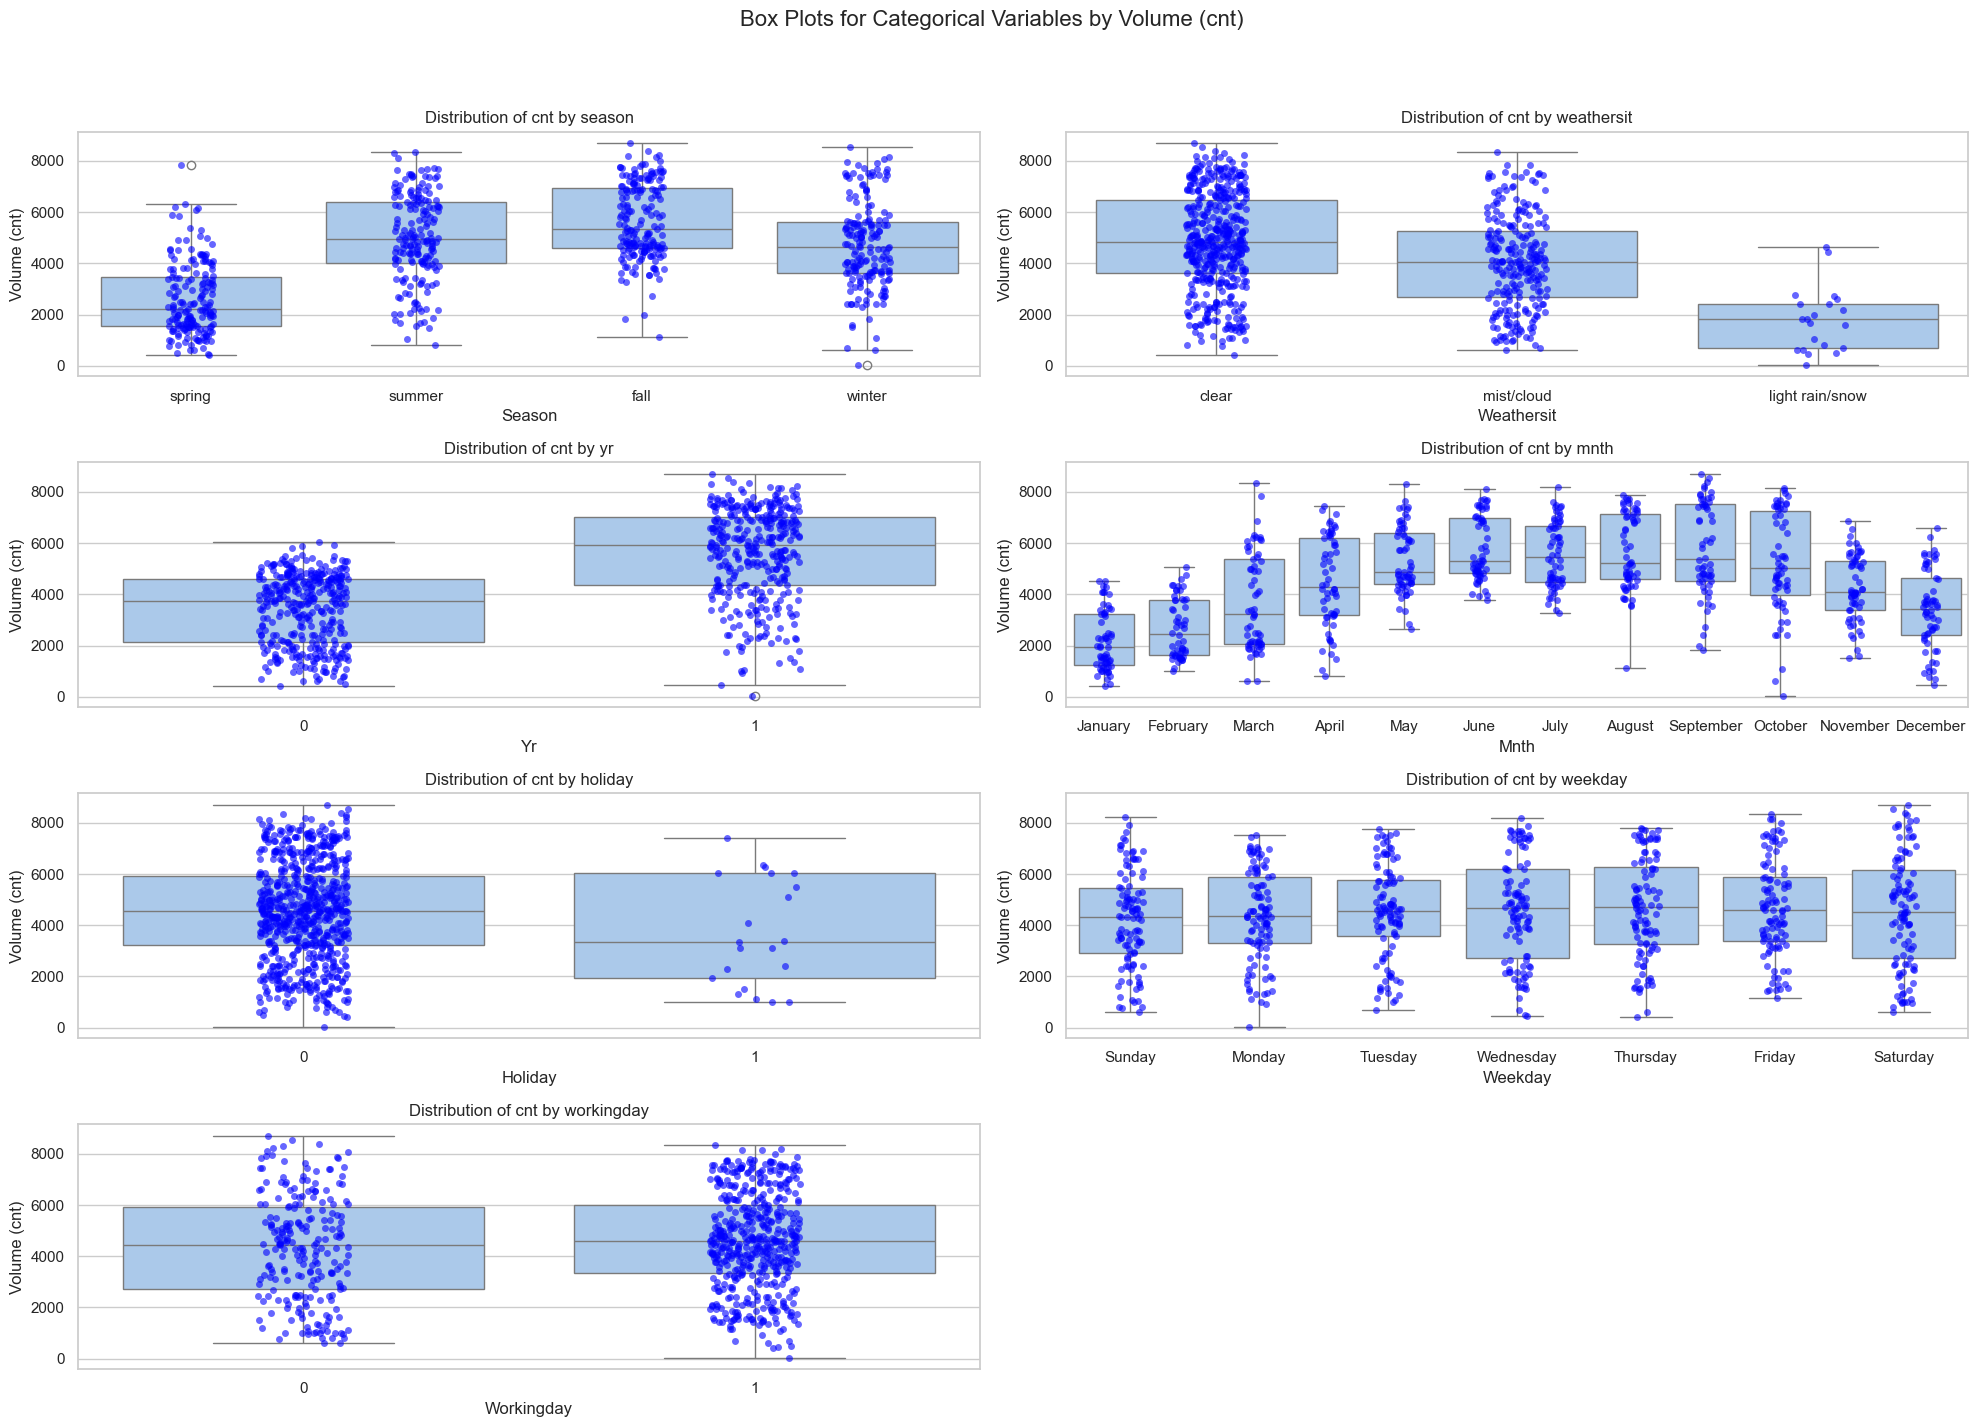

In [13]:
# Plotting box plots for 'cnt' against categorical variables
categorical_vars = ['season', 'weathersit', 'yr', 'mnth', 'holiday', 'weekday', 'workingday']
fig, axes = plt.subplots(4, 2, figsize=(20, 15))
fig.suptitle('Box Plots for Categorical Variables by Volume (cnt)', fontsize=16)

for i, var in enumerate(categorical_vars):
    row, col = divmod(i, 2)
    sns.boxplot(x=var, y='cnt', data=data, ax=axes[row, col])   # Box plot
    sns.stripplot(x=var, y='cnt', data=data, ax=axes[row, col], color='blue', alpha=0.6, jitter=True) # Strip plot
    axes[row, col].set_title(f'Distribution of cnt by {var}')
    axes[row, col].set_xlabel(var.capitalize())
    axes[row, col].set_ylabel('Volume (cnt)')

fig.delaxes(axes[3, 1]) # Remove the extra subplot (axes[3, 1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

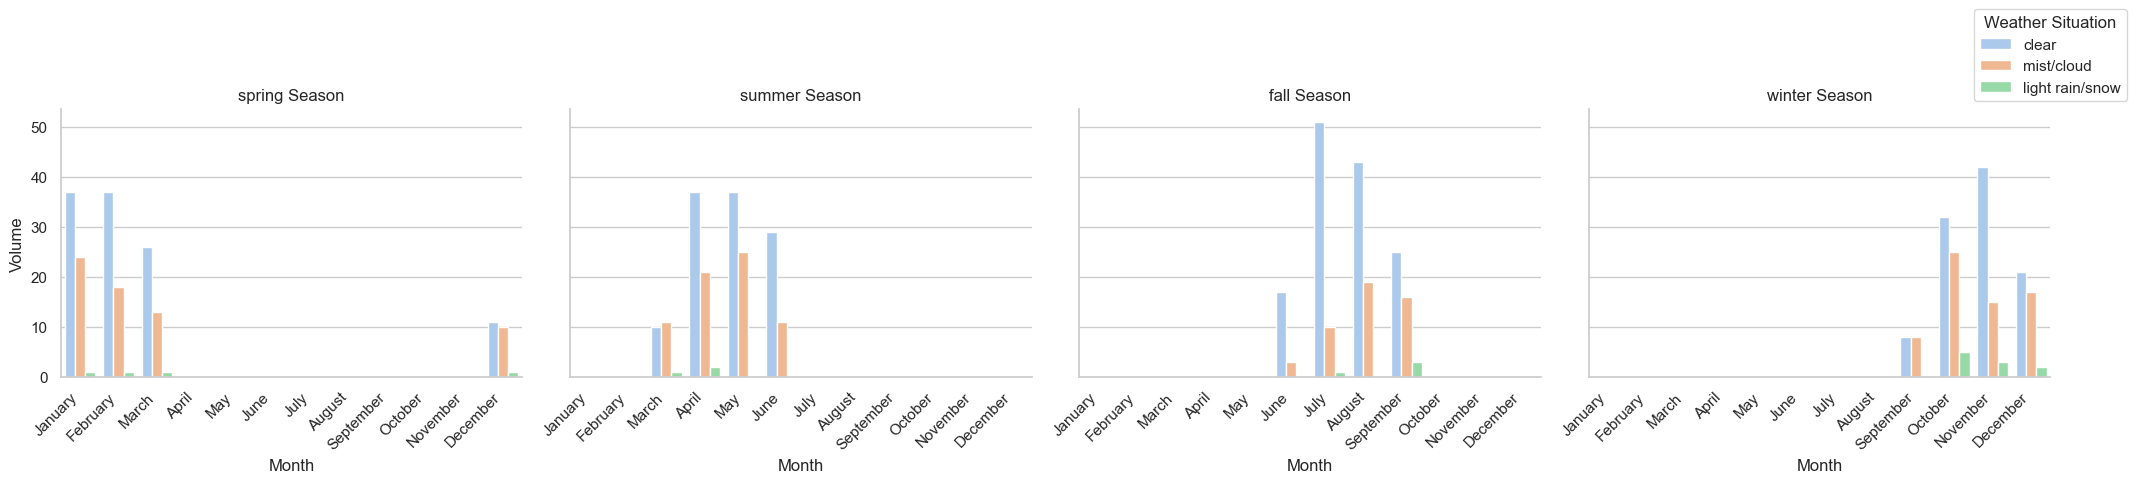

In [14]:
# Creating the count plot with Facet Grid
g = sns.catplot(
    data=data, 
    x='mnth', 
    hue='weathersit', 
    col='season', 
    kind='count', 
    height=5, 
    aspect=1,
    palette='pastel',
)

for ax in g.axes.flat:
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(title='Weather Situation', bbox_to_anchor=(1, 1), loc='lower center', ncol=1)
g.set_axis_labels("Month", "Volume")
g.set_titles("{col_name} Season")
g._legend.remove()
plt.tight_layout()
plt.show()

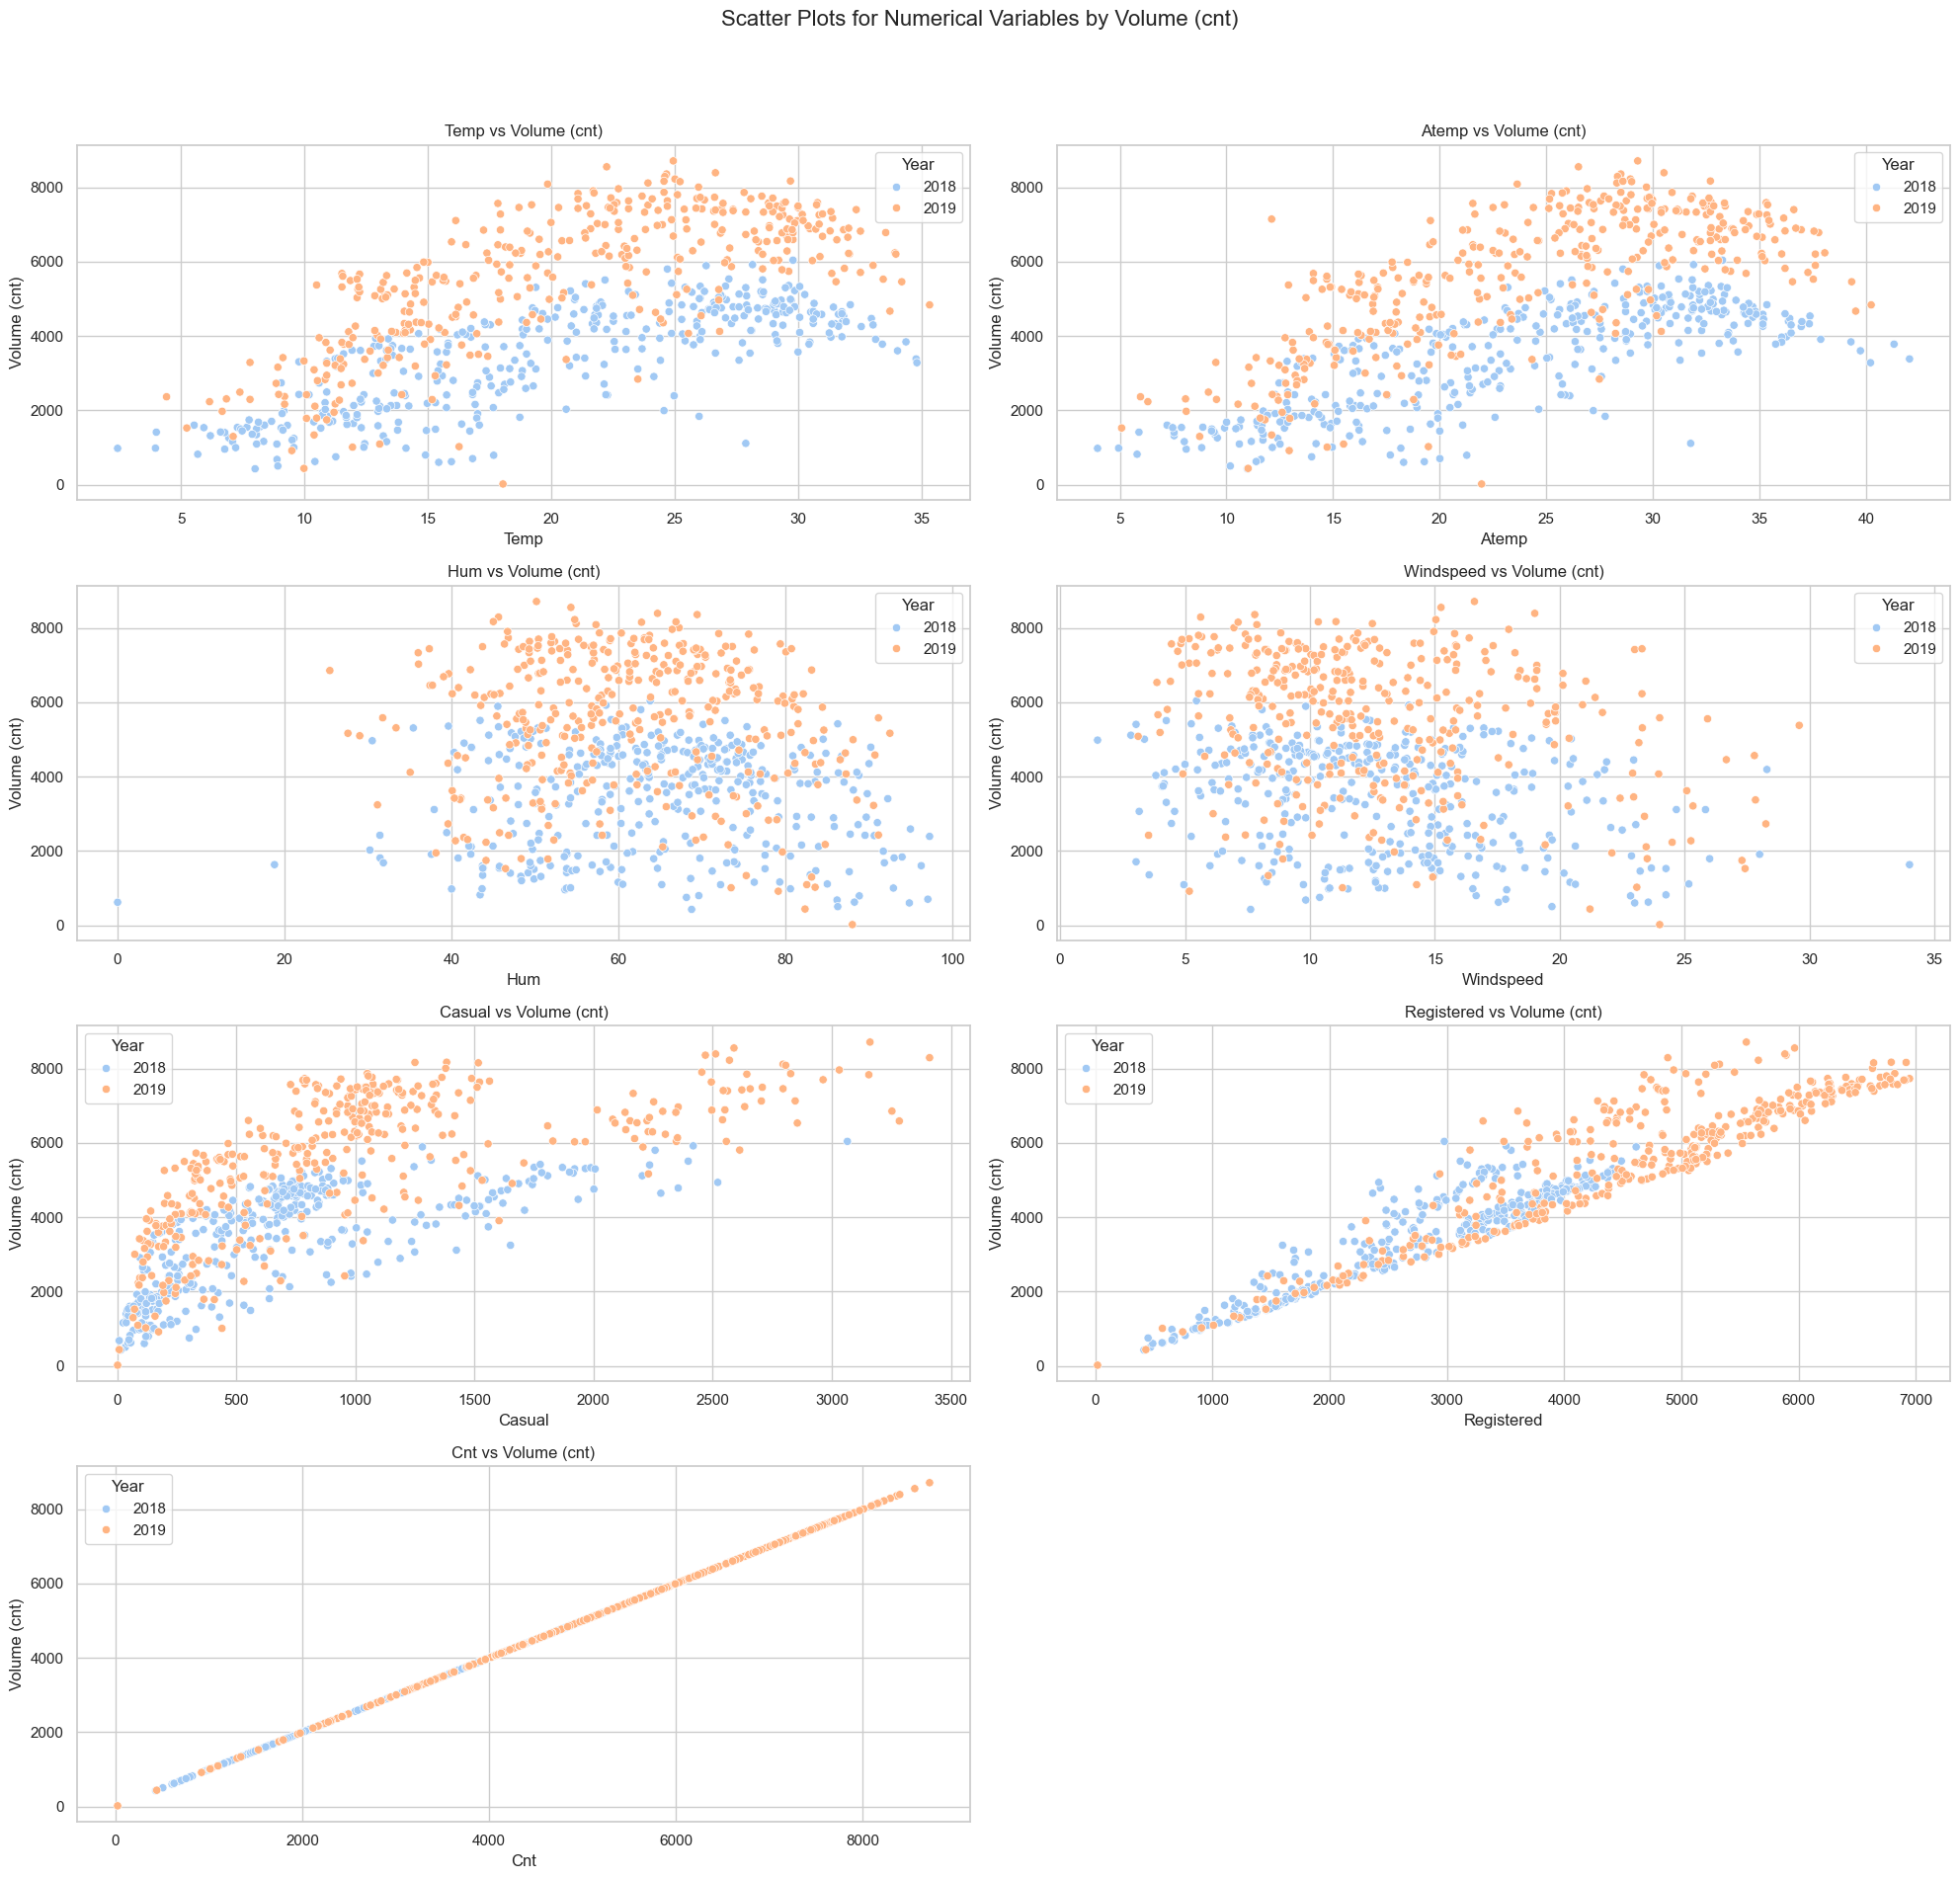

In [15]:
# Scatter plot Numerical variables by years as we want to see 2018 vs 2019
numerical_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle('Scatter Plots for Numerical Variables by Volume (cnt)', fontsize=16)

for i, var in enumerate(numerical_vars):
    row, col = divmod(i, 2)
    sns.scatterplot(x=var, y='cnt', data=data, ax=axes[row, col], hue='yr', palette="pastel")
    axes[row, col].set_title(f'{var.capitalize()} vs Volume (cnt)')
    axes[row, col].set_xlabel(var.capitalize())
    axes[row, col].set_ylabel('Volume (cnt)')
    handles, labels = axes[row, col].get_legend_handles_labels()
    labels = ['2018' if label == '0' else '2019' for label in labels]
    axes[row, col].legend(handles=handles, labels=labels, title='Year')

fig.delaxes(axes[3, 1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

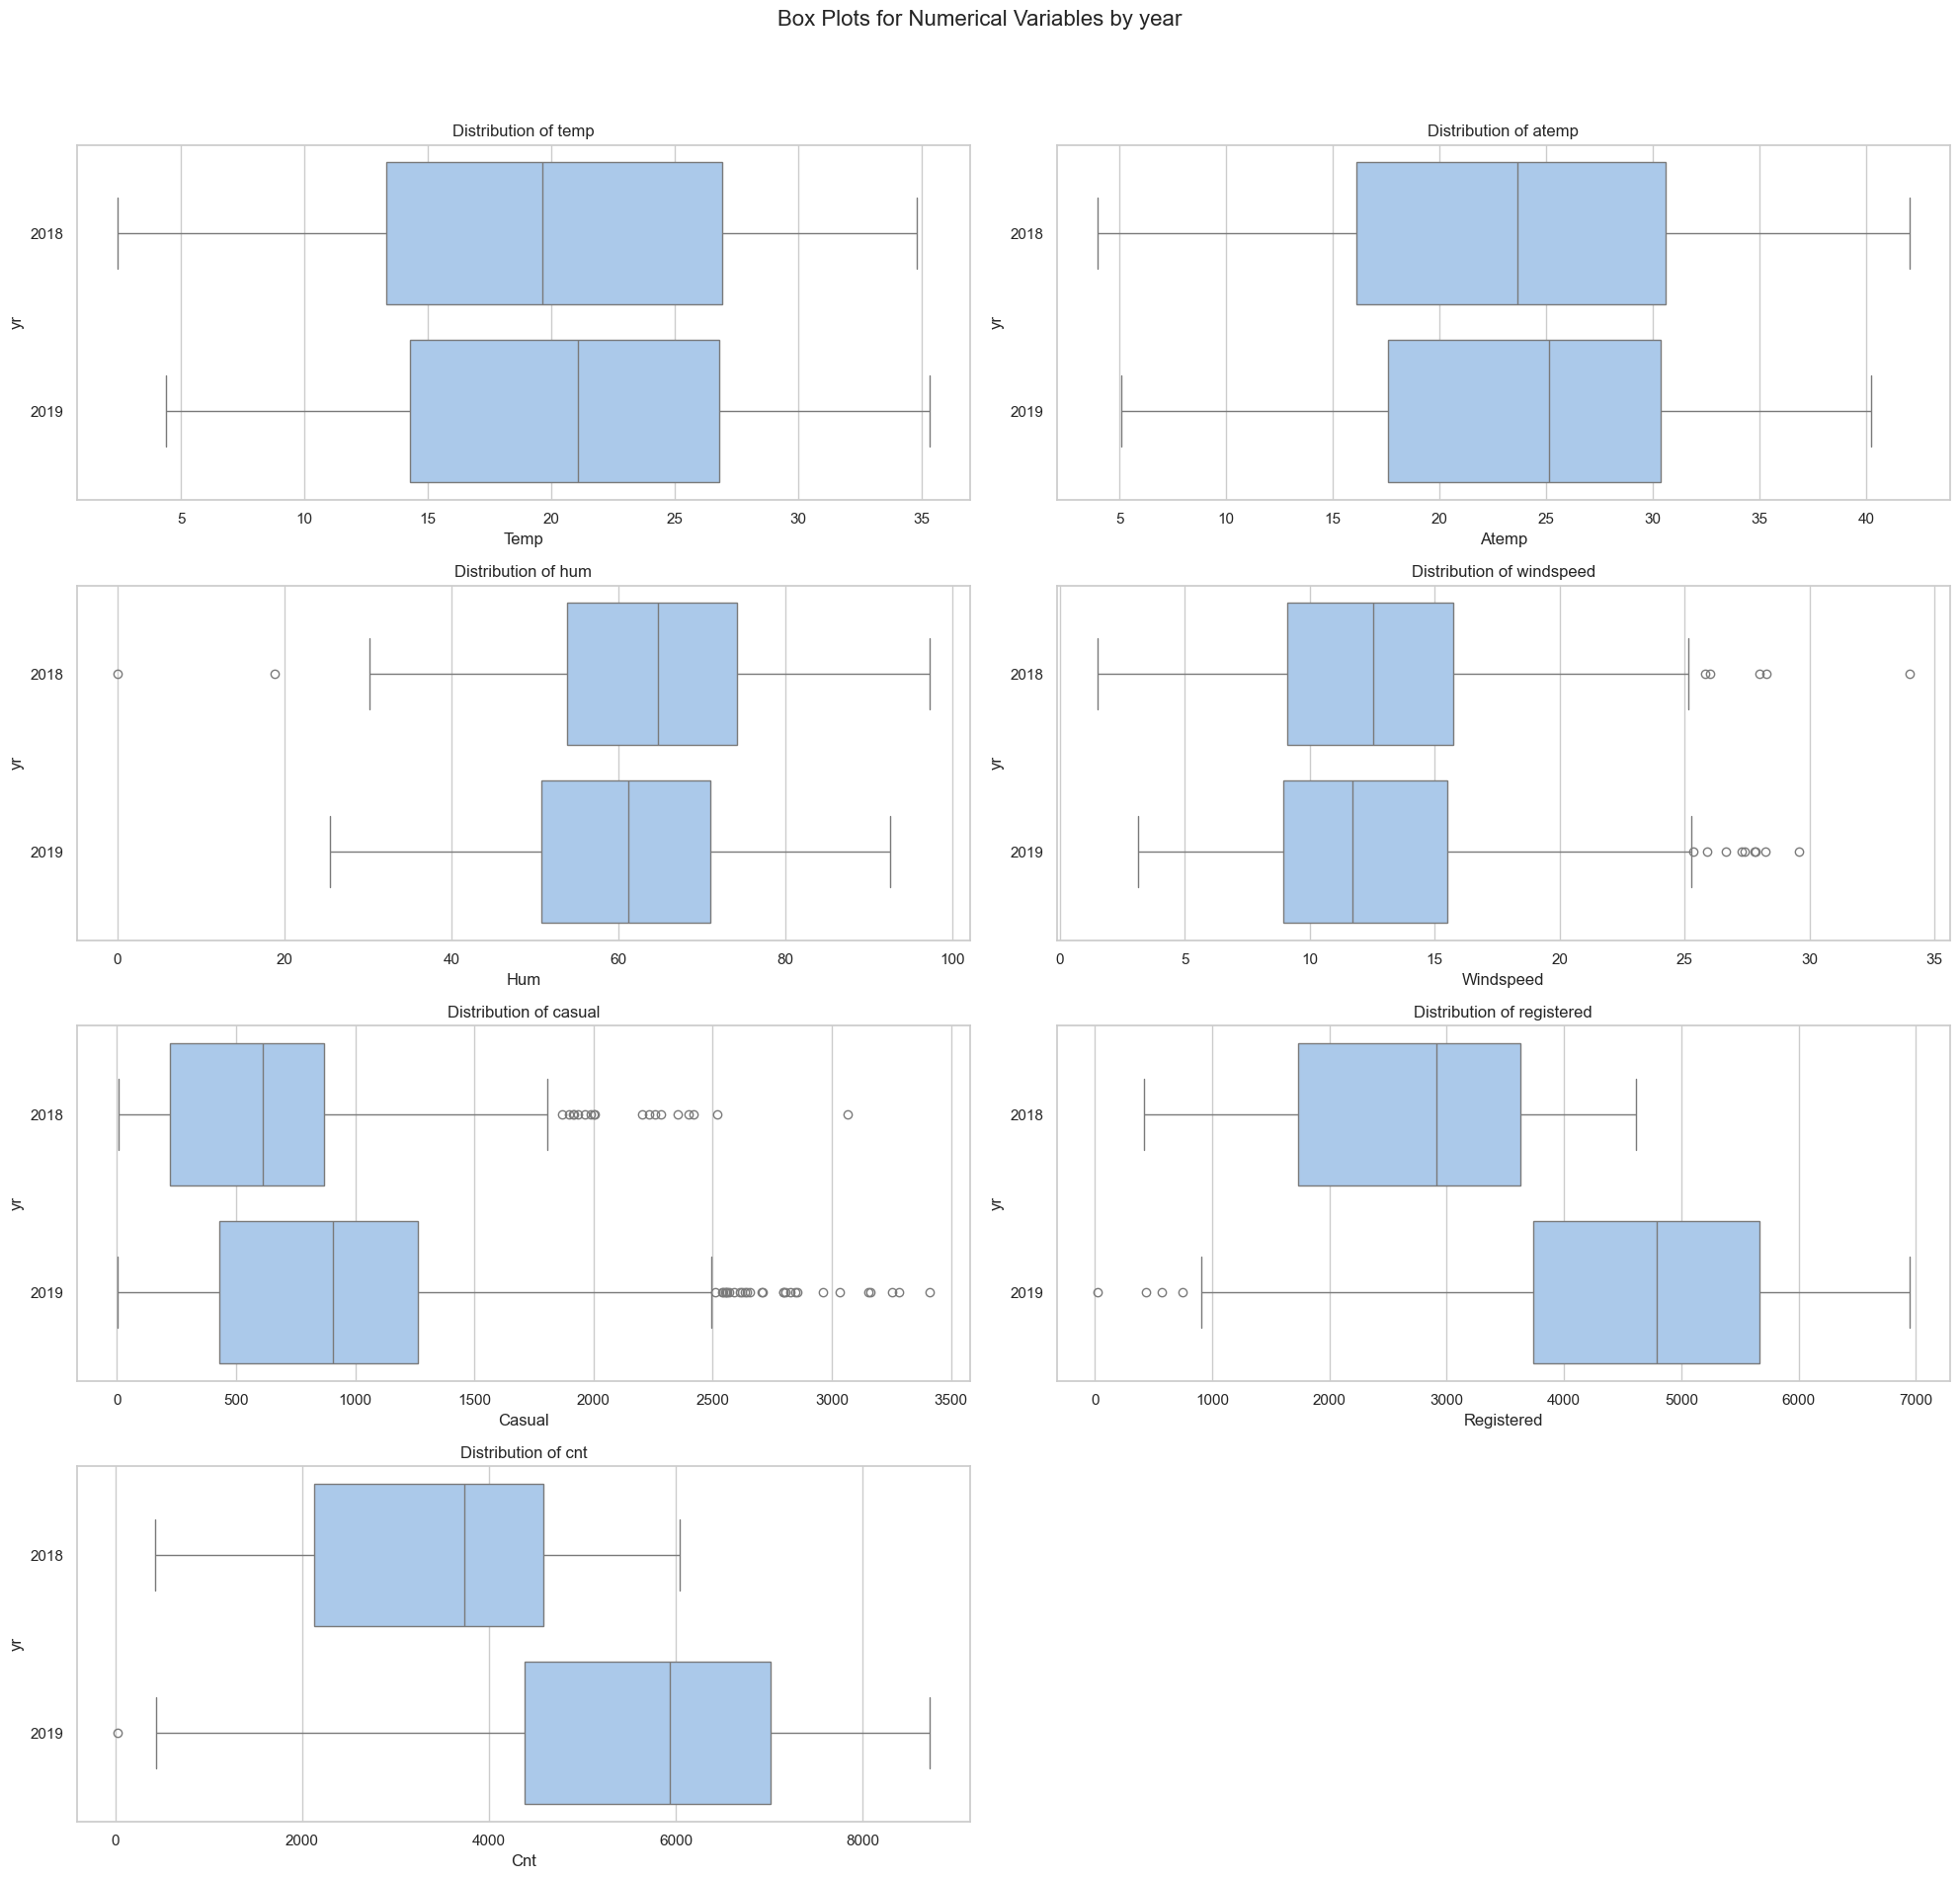

In [16]:
# Let's compare 2018 and 2019 further.

sns.set_theme(style="whitegrid", palette="pastel")

numerical_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

fig, axes = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle('Box Plots for Numerical Variables by year', fontsize=16)

for i, var in enumerate(numerical_vars):
    row, col = divmod(i, 2)
    # sns.boxplot(y=var, data=data, ax=axes[row, col], palette="pastel")
    sns.boxplot(x=var, y='yr', data=data, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {var}')
    axes[row, col].set_xlabel(var.capitalize())
    axes[row, col].set_yticks([0, 1])
    axes[row, col].set_yticklabels(['2018', '2019'])   

fig.delaxes(axes[3, 1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

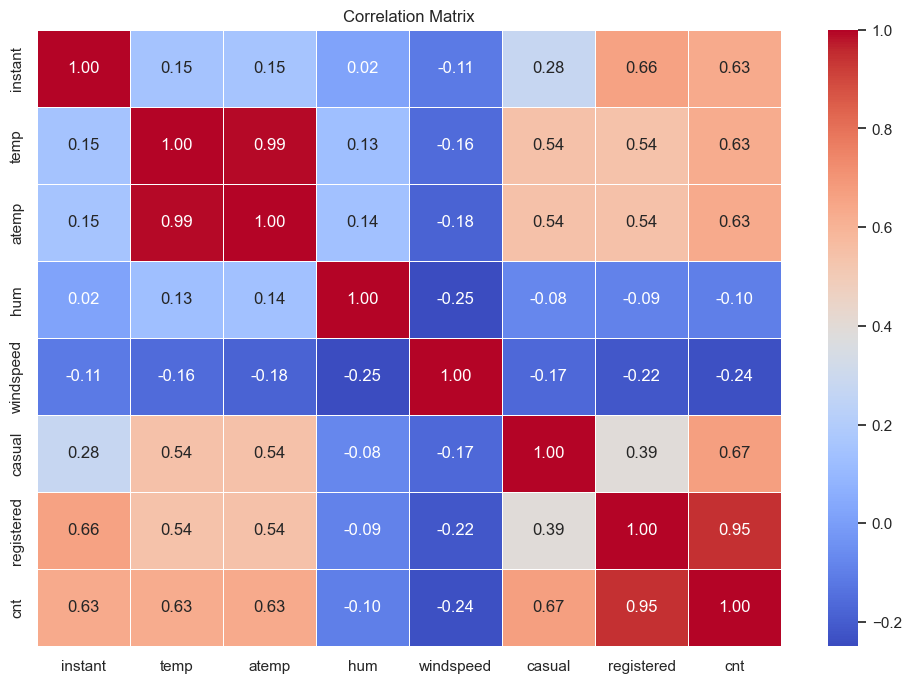

In [17]:
plot_correlation_matrix(data=data, columns=[v for v in data.columns])

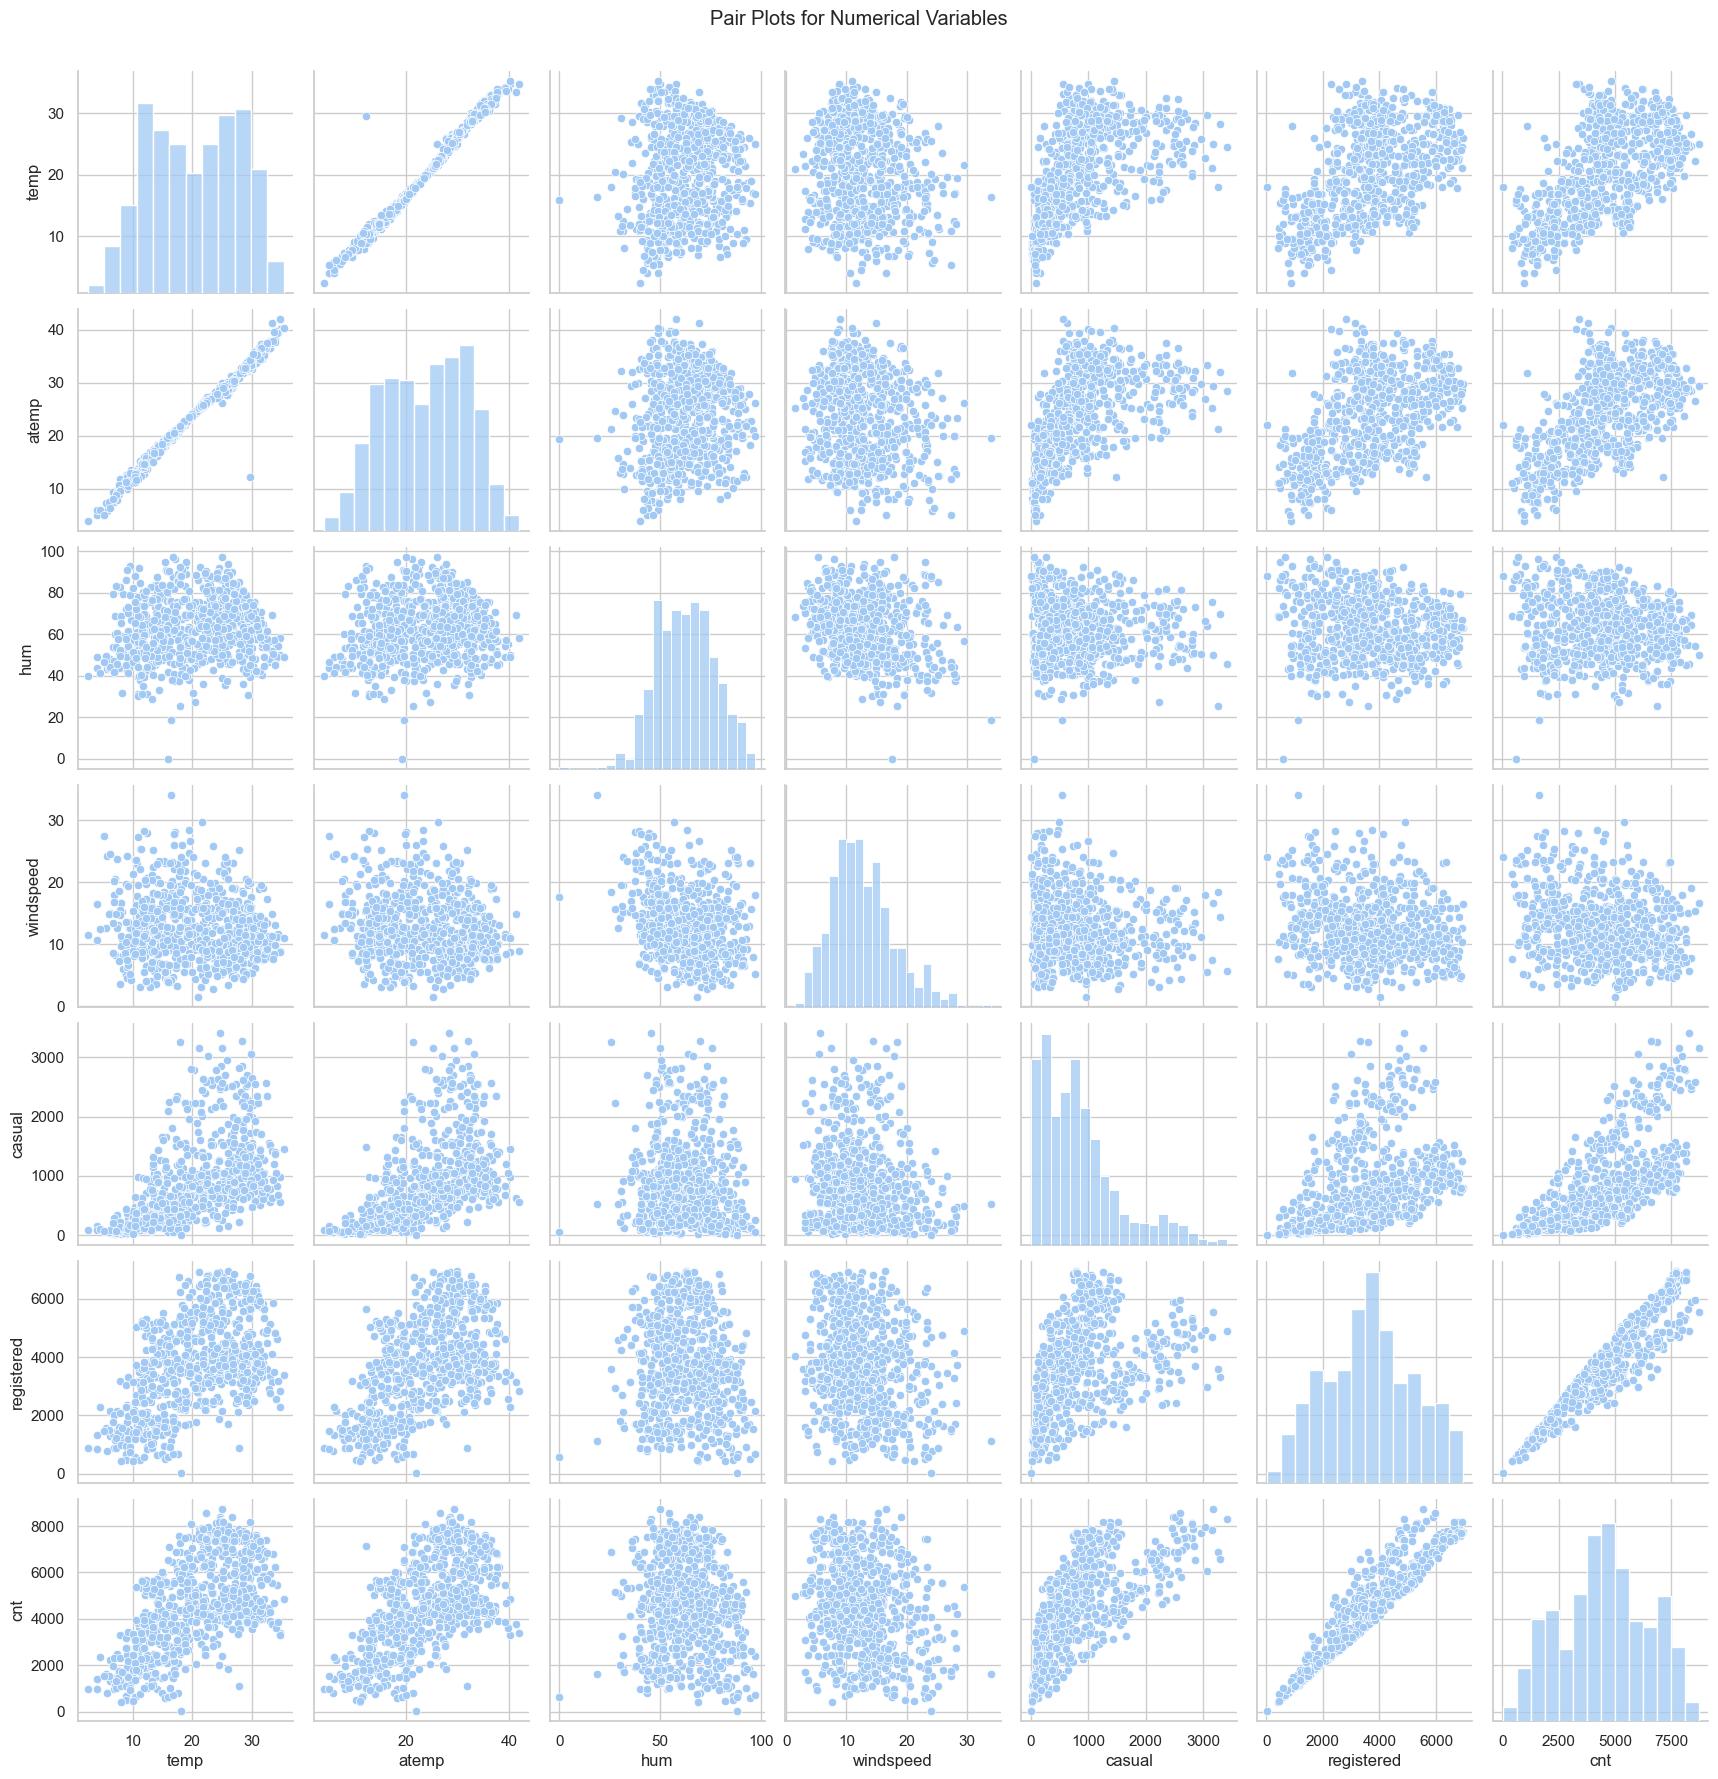

In [18]:
# Creating pair plots for numerical variables
sns.pairplot(data[['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']], kind='scatter')
plt.suptitle('Pair Plots for Numerical Variables', y=1.02)
plt.show()

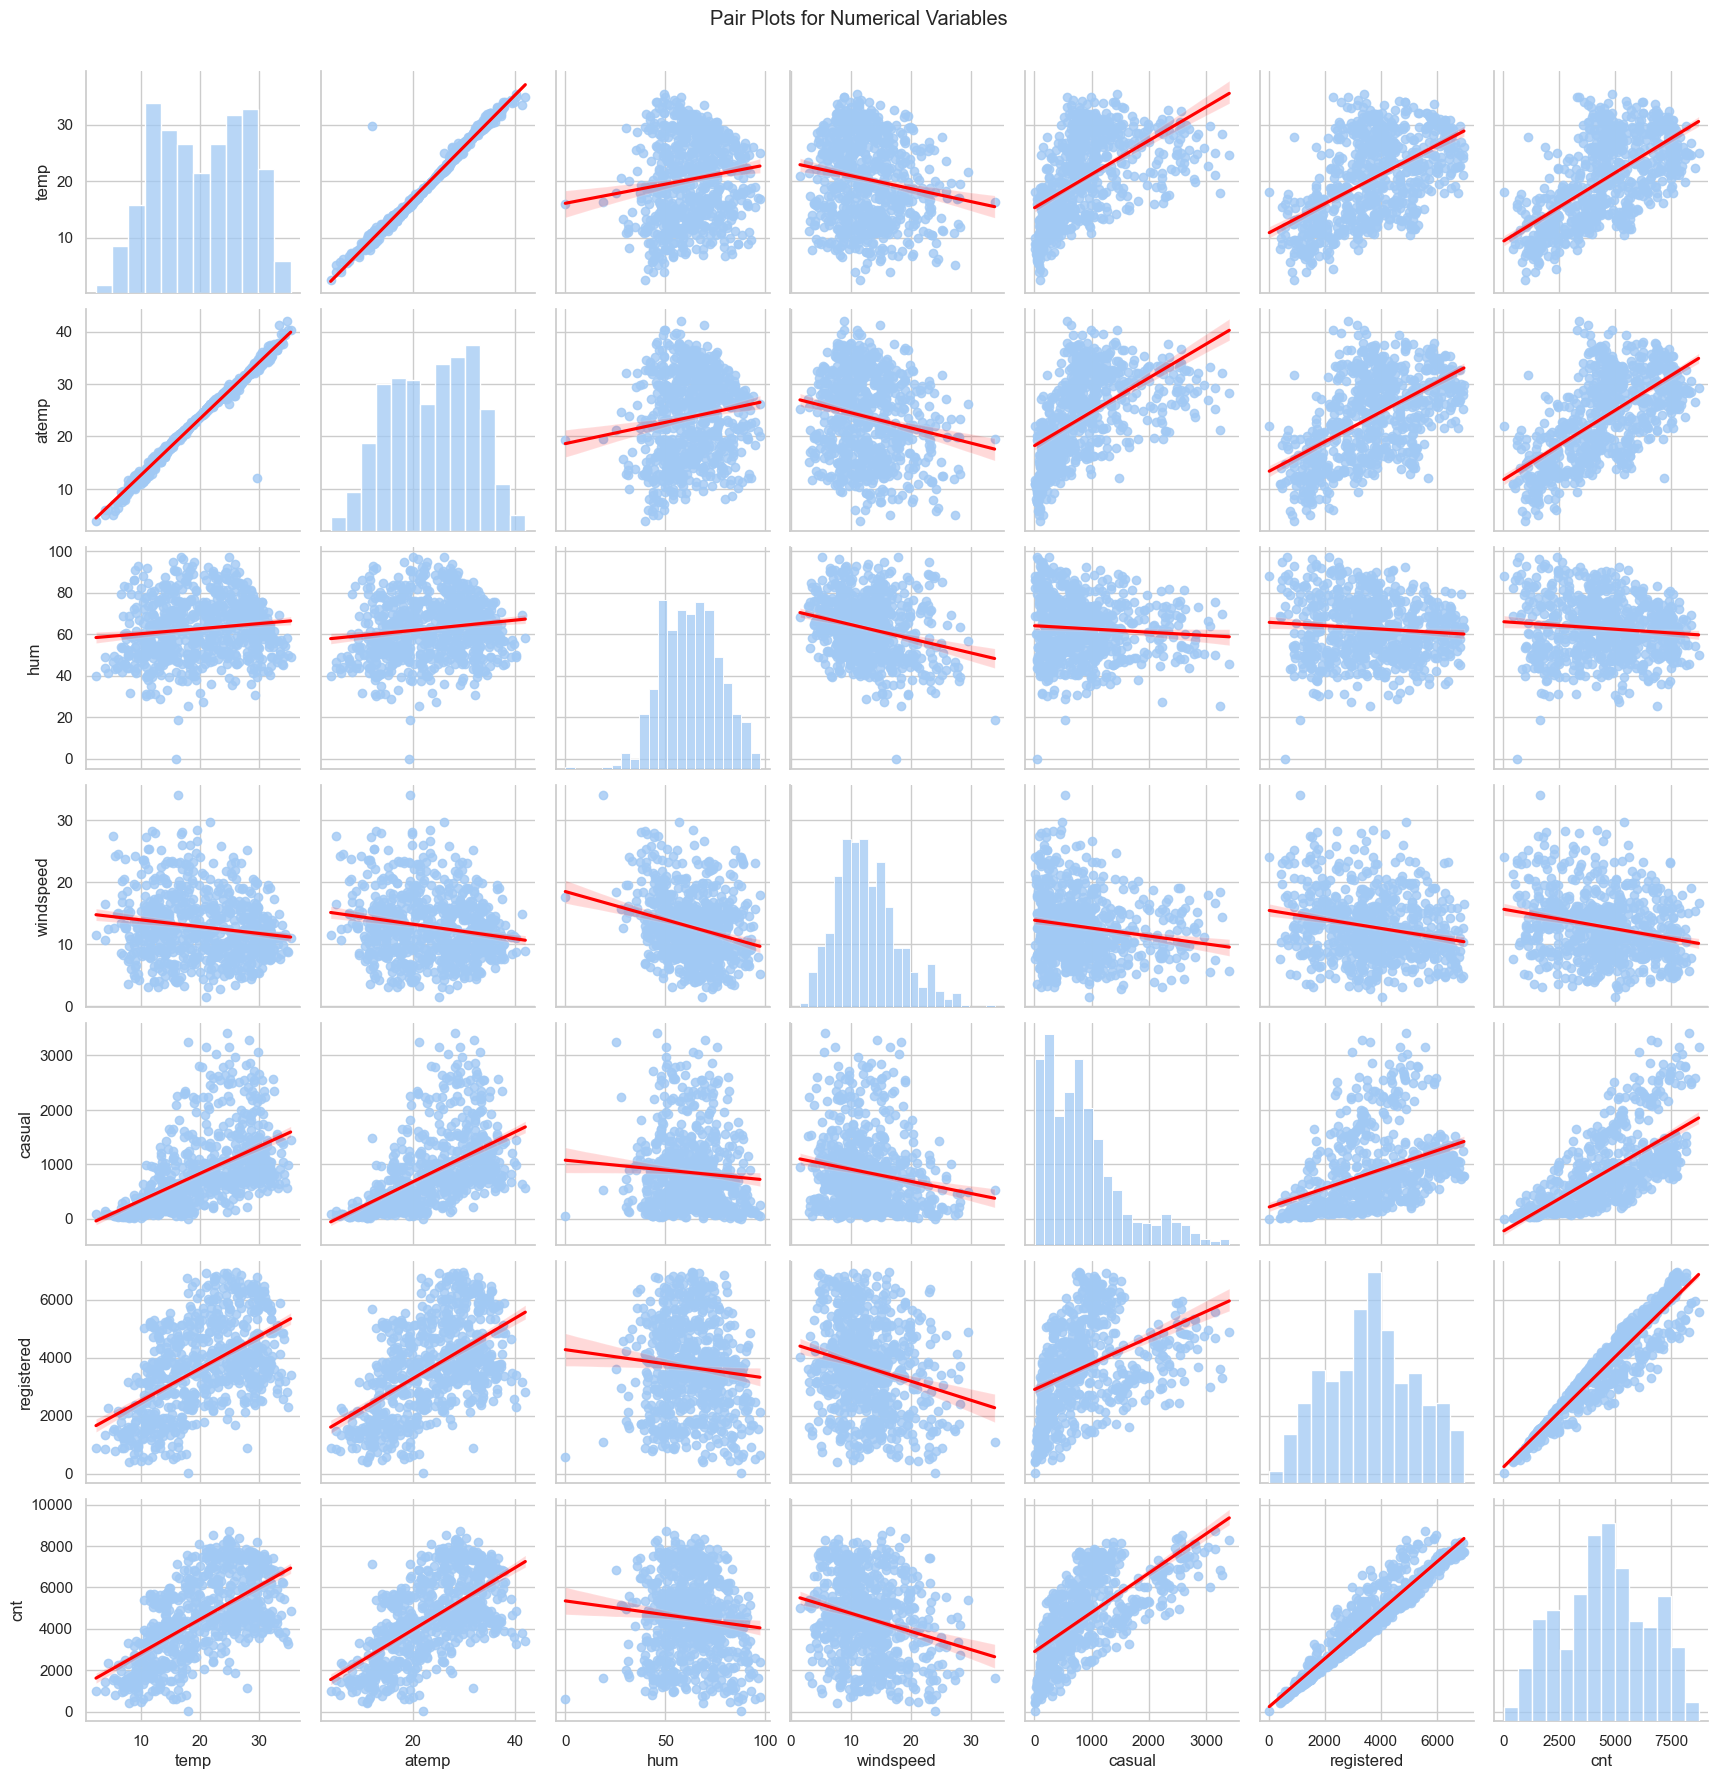

In [19]:
# Creating pair plots for numerical variables with reg
sns.pairplot(data[['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']], 
             kind='reg', 
             plot_kws={'line_kws':{'color':'red'}}
)
plt.suptitle('Pair Plots for Numerical Variables', y=1.02)
plt.show()

In [20]:
# Let's take a look at exact data using cross tabs 
display(ct_x_by_vol(data=data, row='season', volume='cnt'))
display(ct_x_by_vol(data=data, row='yr', volume='cnt'))
display(ct_x_by_vol(data=data, row='holiday', volume='cnt'))
display(ct_x_by_vol(data=data, row='weekday', volume='cnt'))
display(ct_x_by_vol(data=data, row='workingday', volume='cnt'))
display(ct_x_by_vol(data=data, row='weathersit', volume='cnt'))

cnt  percentage
season                     
spring   469514       14.27
summer   918589       27.91
fall    1061129       32.24
winter   841613       25.57

cnt  percentage
yr                     
0   1243103       37.77
1   2047742       62.23

cnt  percentage
holiday                     
0        3212410       97.62
1          78435        2.38

cnt  percentage
weekday                      
Sunday     444027       13.49
Monday     455503       13.84
Tuesday    469109       14.25
Wednesday  471214       14.32
Thursday   485395       14.75
Friday     487790       14.82
Saturday   477807       14.52

cnt  percentage
workingday                     
0           1000269        30.4
1           2290576        69.6

cnt  percentage
weathersit                          
clear            2257952       68.61
mist/cloud        995024       30.24
light rain/snow    37869        1.15

In [21]:
# Let's look at distribution of rental volume for few promising combinations
display(ct_x_by_y_by_vol(data=data, row='mnth', col='season', volume='cnt'))
display(ct_x_by_y_by_vol(data=data, row='weathersit', col='season', volume='cnt'))
display(ct_x_by_y_by_vol(data=data, row='weekday', col='holiday', volume='cnt'))
display(ct_x_by_y_by_vol(data=data, row='weekday', col='workingday', volume='cnt'))

season     spring  summer    fall  winter  spring_percentage  \
mnth                                                           
January    134933       0       0       0               4.10   
February   149518       0       0       0               4.54   
March      142065   86855       0       0               4.32   
April           0  269094       0       0               0.00   
May             0  331686       0       0               0.00   
June            0  230954  115388       0               0.00   
July            0       0  344948       0               0.00   
August          0       0  351194       0               0.00   
September       0       0  249599   96392               0.00   
October         0       0       0  322352               0.00   
November        0       0       0  254831               0.00   
December    42998       0       0  168038               1.31   

season     summer_percentage  fall_percentage  winter_percentage  
mnth                                                              
January                 0.00             0.00               0.00  
February                0.00             0.00               0.00  
March                   2.64             0.00               0.00  
April                   8.18             0.00               0.00  
May                    10.08             0.00               0.00  
June                    7.02             3.51               0.00  
July                    0.00            10.48               0.00  
August                  0.00            10.67               0.00  
September               0.00             7.58               2.93  
October                 0.00             0.00               9.80  
November                0.00             0.00               7.74  
December                0.00             0.00               5.11

season           spring  summer    fall  winter  spring_percentage  \
weathersit                                                           
clear            312036  626986  799443  519487               9.48   
mist/cloud       153739  288096  250679  302510               4.67   
light rain/snow    3739    3507   11007   19616               0.11   

season           summer_percentage  fall_percentage  winter_percentage  
weathersit                                                              
clear                        19.05            24.29              15.79  
mist/cloud                    8.75             7.62               9.19  
light rain/snow               0.11             0.33               0.60

holiday         0      1  0_percentage  1_percentage
weekday                                             
Sunday     444027      0         13.49          0.00
Monday     395898  59605         12.03          1.81
Tuesday    468096   1013         14.22          0.03
Wednesday  463811   7403         14.09          0.22
Thursday   481475   3920         14.63          0.12
Friday     481296   6494         14.63          0.20
Saturday   477807      0         14.52          0.00

workingday       0       1  0_percentage  1_percentage
weekday                                               
Sunday      444027       0         13.49          0.00
Monday       59605  395898          1.81         12.03
Tuesday       1013  468096          0.03         14.22
Wednesday     7403  463811          0.22         14.09
Thursday      3920  481475          0.12         14.63
Friday        6494  481296          0.20         14.63
Saturday    477807       0         14.52          0.00

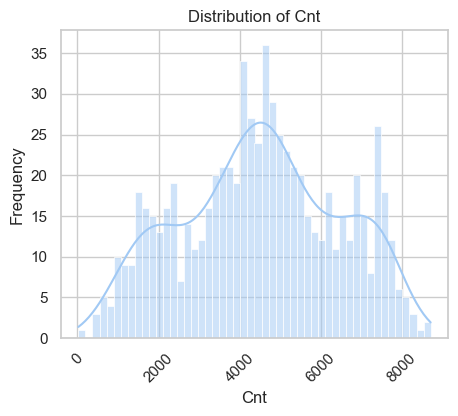

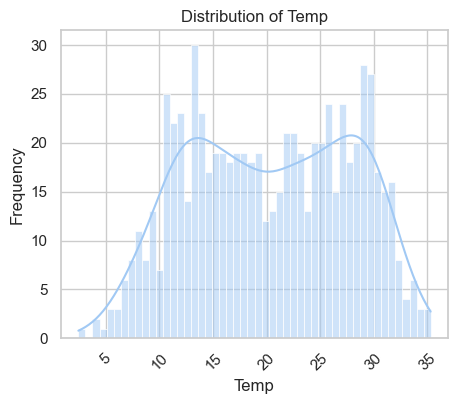

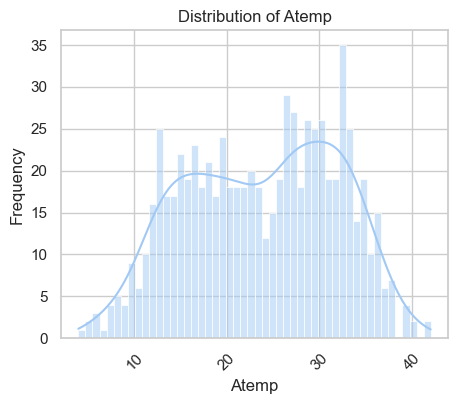

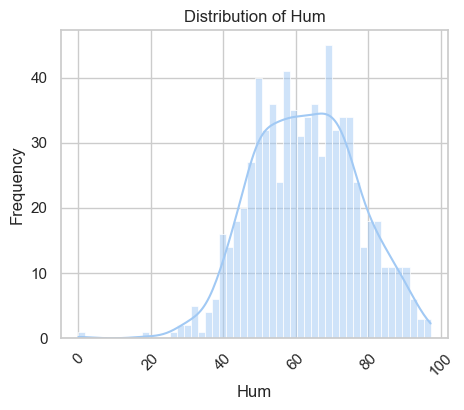

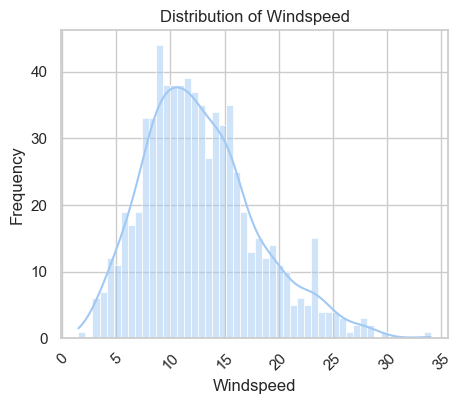

In [22]:
# Let's check distribution
variables = ['cnt', 'temp', 'atemp', 'hum', 'windspeed']

# Create a histogram with KDE line for each variable
for var in variables:
    plt.figure(figsize=(5, 4))
    sns.histplot(data[var], bins=50, kde=True)
    plt.xlabel(var.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {var.capitalize()}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

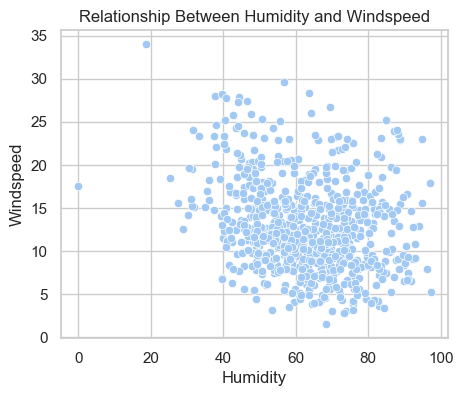

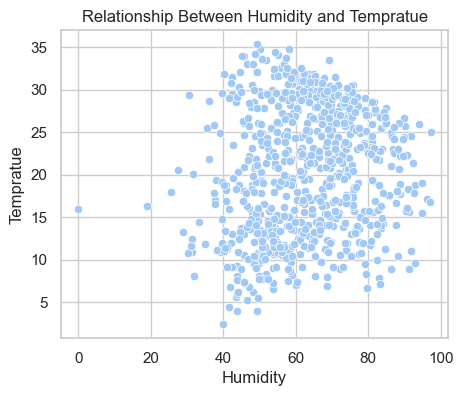

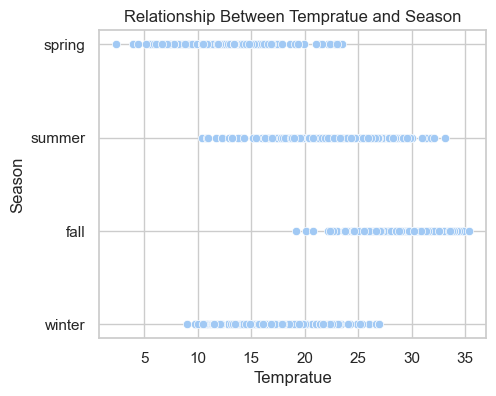

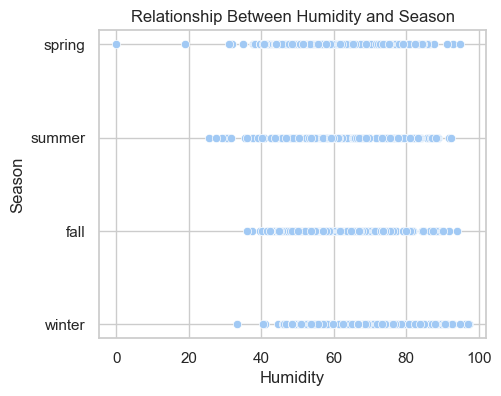

In [23]:
# Exploring relationship of few more variables.

plt.figure(figsize=(5, 4))
sns.scatterplot(data=data, x='hum', y='windspeed', alpha=1)
plt.xlabel('Humidity')
plt.ylabel('Windspeed')
plt.title('Relationship Between Humidity and Windspeed')
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 4))
sns.scatterplot(data=data, x='hum', y='temp', alpha=1)
plt.xlabel('Humidity')
plt.ylabel('Tempratue')
plt.title('Relationship Between Humidity and Tempratue')
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 4))
sns.scatterplot(data=data, x='temp', y='season', alpha=1)
plt.xlabel('Tempratue')
plt.ylabel('Season')
plt.title('Relationship Between Tempratue and Season')
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 4))
sns.scatterplot(data=data, x='hum', y='season', alpha=1)
plt.xlabel('Humidity')
plt.ylabel('Season')
plt.title('Relationship Between Humidity and Season')
plt.grid(True)
plt.show()

---- temp ----


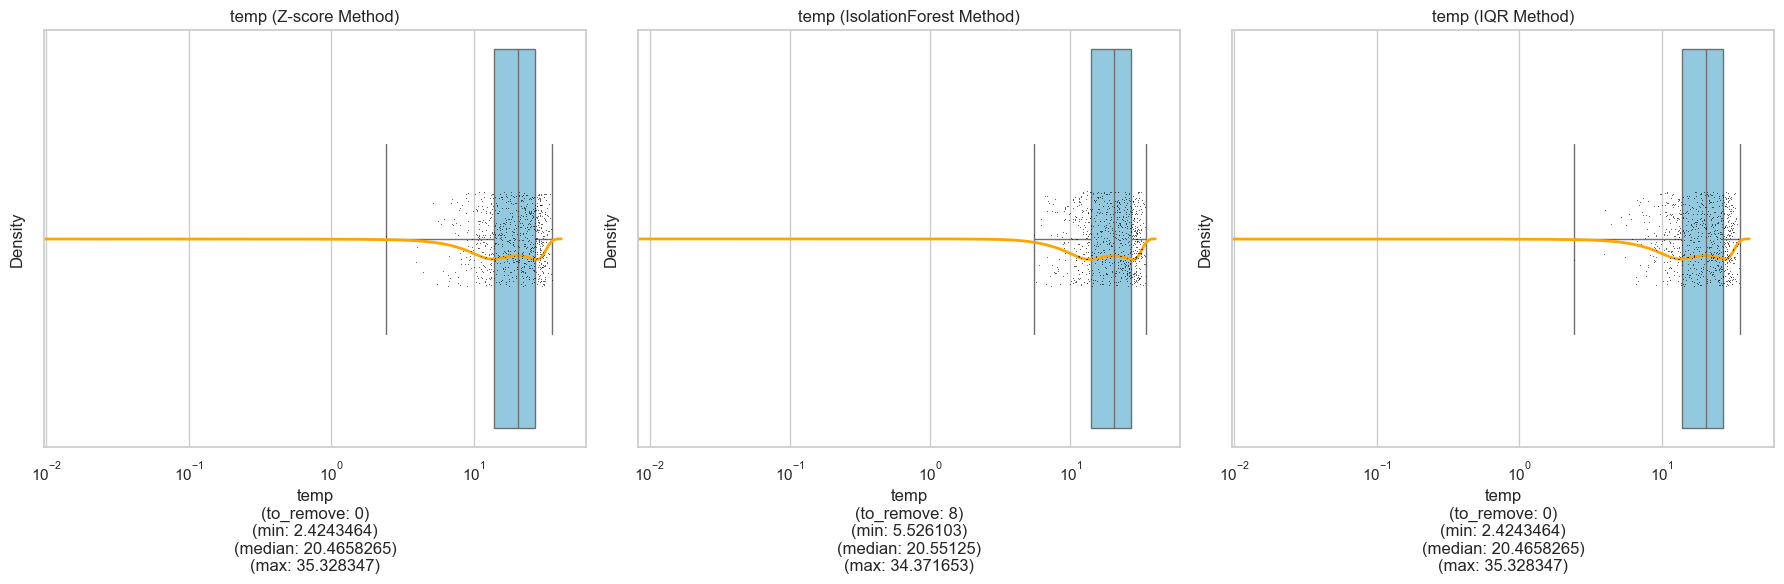

---- hum ----


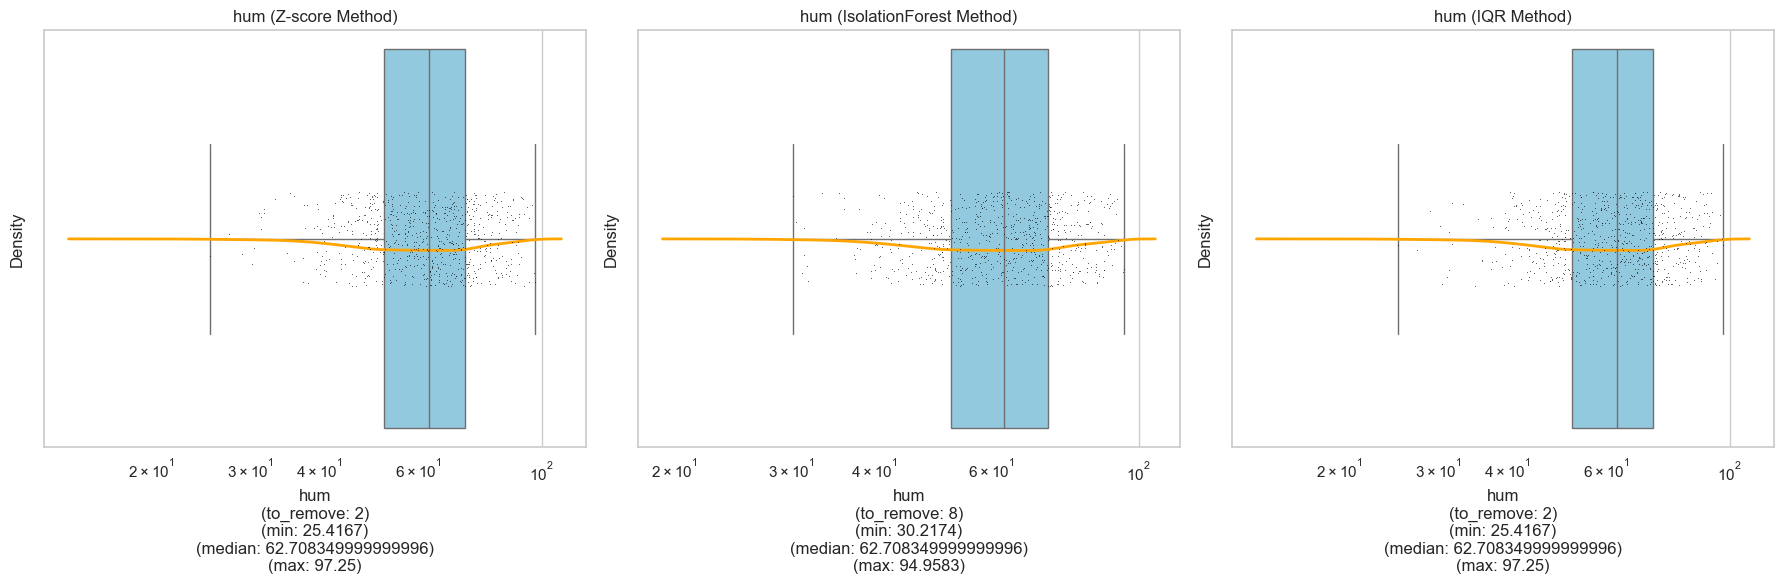

---- windspeed ----


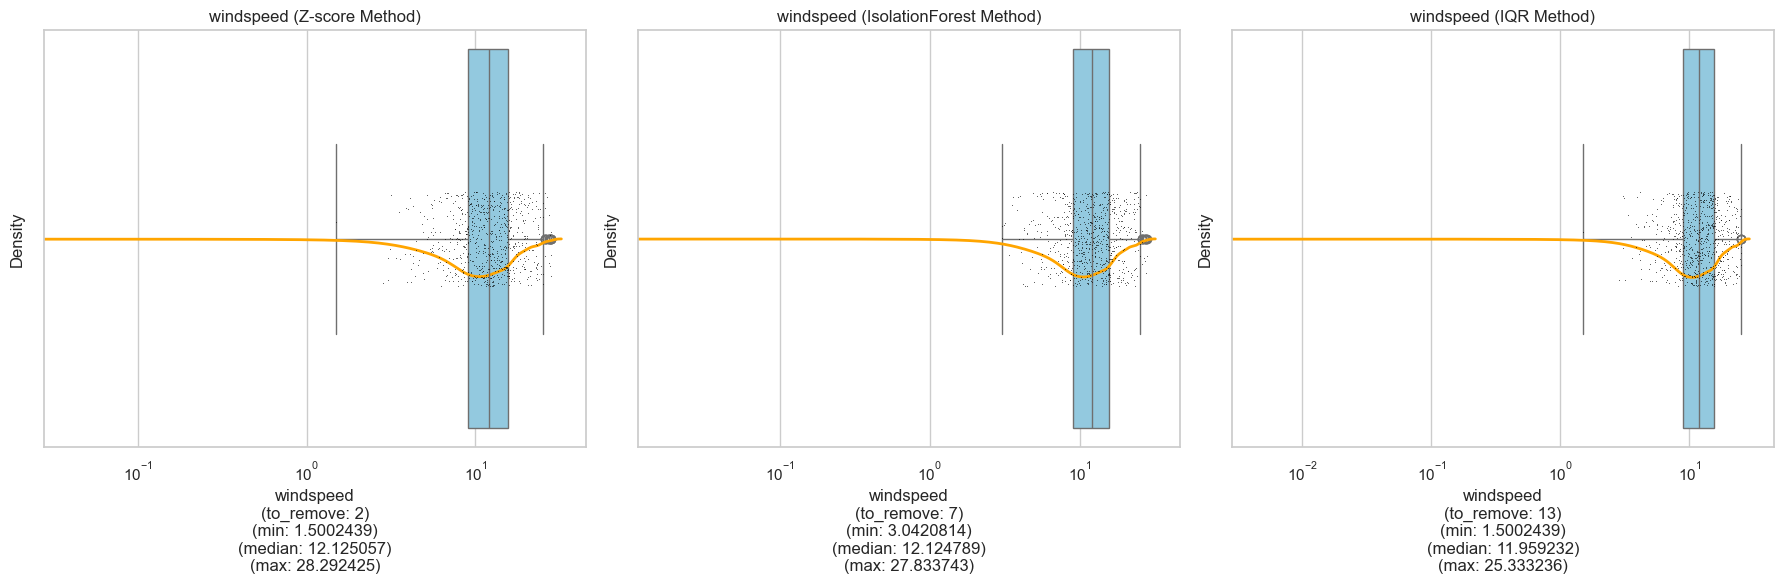

---- cnt ----


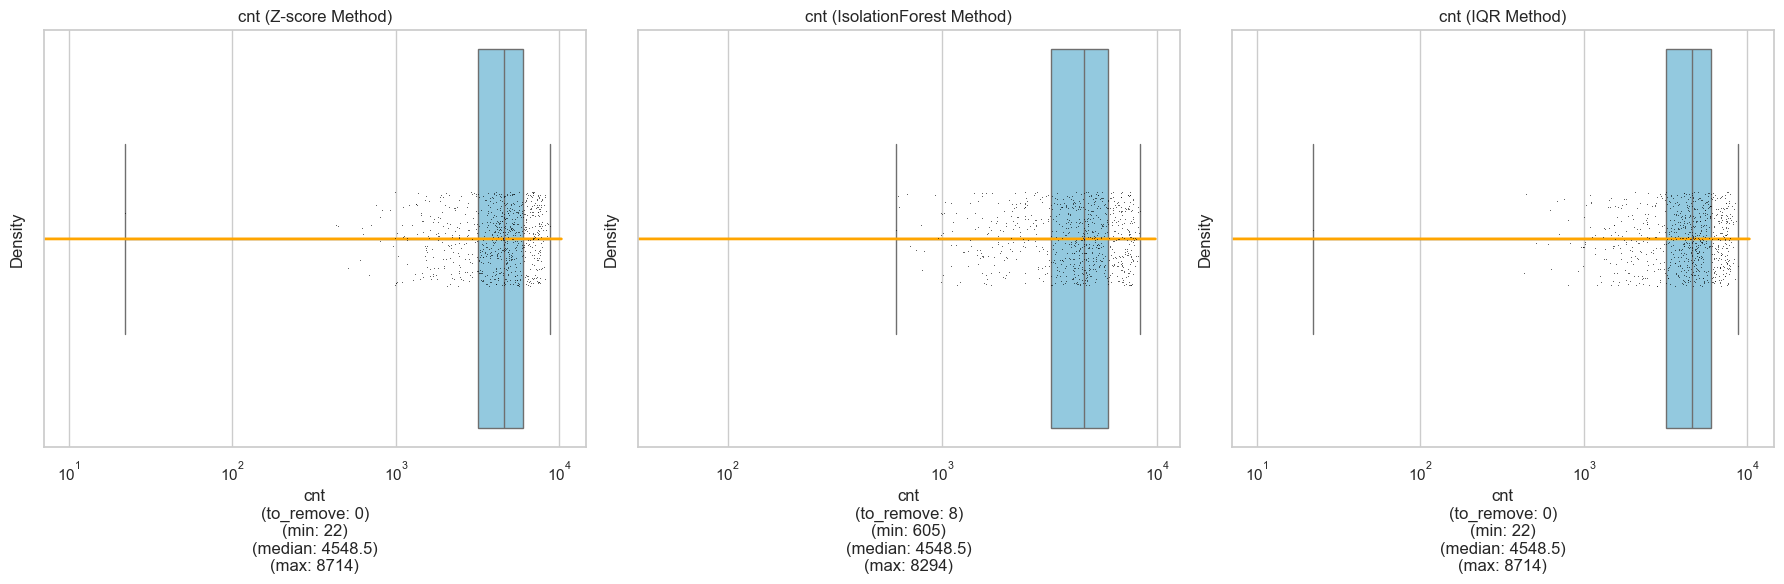

In [24]:
analyze_and_plot_outliers(data, 'temp')
# analyze_and_plot_outliers(data, 'atemp')      # Because we removed the varible to avoid `multicollinearity`
analyze_and_plot_outliers(data, 'hum')
analyze_and_plot_outliers(data, 'windspeed')
# analyze_and_plot_outliers(data, 'casual')     # Because we removed the varible to avoid `multicollinearity`
# analyze_and_plot_outliers(data, 'registered') # Because we removed the varible to avoid `multicollinearity`
analyze_and_plot_outliers(data, 'cnt')

##### Capping outliers

We have few outliers in the data. I will cap the outliers using Isolation Forest

In [25]:
# Quick summary before capping
detailed_descriptive_numerical(data[['temp', 'hum', 'windspeed', 'cnt']])

count     mean      std    min      25%      50%      75%      max  \
temp       730.0    20.32     7.51   2.42    13.81    20.47    26.88    35.33   
hum        730.0    62.77    14.24   0.00    52.00    62.62    72.99    97.25   
windspeed  730.0    12.76     5.20   1.50     9.04    12.13    15.63    34.00   
cnt        730.0  4508.01  1936.01  22.00  3169.75  4548.50  5966.00  8714.00   

           missing_values      skew  kurtosis         mode  
temp                    0 -0.057187 -1.118305    10.899153  
hum                     0 -0.067476 -0.059830    61.333300  
windspeed               0  0.676314  0.405909     7.125450  
cnt                     0 -0.049581 -0.808080  1096.000000

In [26]:
data = cap_outliers_isolation_forest(
    data=data.copy(deep=True), 
    columns=['temp', 'hum', 'windspeed', 'cnt'], 
    contamination=0.01) # Capping 10% of outliers

Capped outliers in temp
Capped outliers in hum
Capped outliers in windspeed
Capped outliers in cnt


In [27]:
# Checking capping
detailed_descriptive_numerical(data[['temp', 'hum', 'windspeed', 'cnt']])

count     mean      std     min      25%      50%      75%  \
temp       730.0    20.33     7.48    5.53    13.81    20.47    26.88   
hum        730.0    62.83    14.01   30.22    52.00    62.62    72.99   
windspeed  730.0    12.75     5.15    3.04     9.04    12.13    15.63   
cnt        730.0  4508.24  1930.67  605.00  3169.75  4548.50  5966.00   

               max  missing_values      skew  kurtosis        mode  
temp         34.37               0 -0.045841 -1.154151    5.526103  
hum          94.96               0  0.053790 -0.554117   30.217400  
windspeed    27.83               0  0.623380  0.135519   27.833743  
cnt        8294.00               0 -0.048063 -0.832465  605.000000

EDA Summary

For our bike ride-sharing dataset covering the years 2018 and 2019, we analyzed various factors influencing bike rental volume (`cnt`). The EDA aimed to understand how different variables impact rental volume and identify any differences between the two years. Here are the key findings:

`Incorrect dtedate variable has made it difficult to validay weekday. I am guessing 0 is Sunday, it is reasonbly good guess, neverthless it would have been better to have this data.`

**Seasonal Trends (`season`)**: Rental volume is highest during the fall (32.24%) and summer (27.91%), with winter (25.57%) and spring (14.27%) showing lower volumes. Monthly breakdown shows peaks in rental volume during summer months (April, May, and June) and fall months (July, August, and September).

**Yearly Comparison (`yr`)**: There is a significant increase in rental volume from 2018 (`0`: 37.77%) to 2019 (`1`: 62.23%). This indicates a growing trend in bike rentals over time.

**Weather Conditions (`weathersit`)**: Clear weather conditions (1) are associated with the highest rental volumes (68.61%), followed by misty/cloudy (2) conditions (30.24%). Light rain/snow (3) conditions see a significant drop in volume (1.15%). `Notably, there are no rental records for extreme weather conditions` (4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog). This could be due to either the absence of such weather conditions in 2018 and 2019 or zero bike rentals during such conditions. However, `we cannot validate this as <dteday> data is junk`.

**Monthly Trends (`mnth`)**: Rental volumes peak during the summer months (June, July, and August) and are lowest in winter months (December and January). Notably, June shows a transition with both summer and fall volumes being high.

**Weekday vs. Weekend (`weekday` and `workingday`)**: There is a consistent rental volume throughout the weekdays, with a slight dip on weekends. Working days (69.6%) have a higher rental volume compared to non-working days (30.4%).

**Holiday Impact (`holiday`)**: Rental volume tends to be lower on holidays (2.38%) compared to non-holidays (97.62%).

**Temperature (`temp` and `atemp`)**: There is a positive correlation between temperature and rental volume. As the temperature increases, rental volume tends to increase.

**Humidity (`hum`)**: Humidity shows a negative correlation with rental volume. Higher humidity levels are associated with lower rental volumes.

**Wind Speed (`windspeed`)**: Wind speed has a slightly negative correlation with rental volume, indicating that higher wind speeds might discourage bike rentals.

**User Type (`casual` and `registered`)**: Registered users consistently show higher rental volumes compared to casual users. Both user types show a positive correlation with overall rental volume.

**Correlation Matrix**: The correlation matrix highlights that `temp`, `atemp`, and `registered` have strong positive correlations with `cnt`. In contrast, `windspeed` and `hum` have weak negative correlations.

#### Final Decisions based on EDA for Model Building

Based on the EDA and my latest findings, here are my final decisions for building the linear regression model to predict rental volume (`cnt`):

**Holiday (`holiday`)**: Given the small percentage of holiday data (2.38%), I will drop this variable as it may not significantly contribute to the model.

**Weather Conditions (`weathersit`)**: I will simplify the `weathersit` variable by focusing on categories 1 (clear) and 2 (mist/cloud). Since extreme weather conditions (category 4) are absent, and light rain/snow (category 3) contributes very little (1.15%) to the overall data, I will `drop these rows` entirely.

**User Type (`casual` and `registered`)**: Since `cnt` is the sum of `casual` and `registered`, these variables are inherently correlated. For the initial model, I will exclude `casual` and `registered` to avoid multicollinearity. If separate insights for different user types are desired, these variables can be included in future.

**Interaction Terms**: Based on the interaction plot between `temp` and `season`, it appears that temperature ranges differ across seasons. I will create interaction terms between `temp` and `season` to capture these seasonal variations. For example, I will create a feature for high temperatures in summer and another for low temperatures in winter.

**Temperature Groups**: Since `temp` is continuous, I will create groups or bins (e.g., low, medium, high) and then create interaction terms with `season`.

**One-Hot Encoding**: I will apply one-hot encoding to categorical variables like `season`, `weekday`, and `weathersit` (after simplifying it as mentioned above).

**Standardization**: I will use `MinMaxScaler` to standardize numerical variables (`temp`, `atemp`, `hum`, `windspeed`). This method scales the data to a range of 0 to 1, which is suitable given the distributions observed in the histograms.

**No Transformation Needed for `cnt`**: The histogram of `cnt` indicates that it is not highly skewed, so no further transformation is necessary for normalizing this variable.

**Temperature Variables**: Due to the high correlation between `temp` and `atemp` (0.99), I will include only one of these variables in the model to avoid multicollinearity issues. Based on the plots, `temp` will be preferred due to its direct measurement.

**Checking Model Assumptions**: After building the initial model, I will check for assumptions of linear regression, such as `linearity`, `multicollinearity`, `homoscedasticity`, `independence `, and `normality of residuals` and make adjustments if needed.


**Outliers**: Data has `very few outliers` and I have capped it for columns `['temp', 'hum', 'windspeed', 'cnt']`. I did not cap for `atemp`, `casual` and `registered` as I am cofident to remove these column based on correlation matrix and pairplots.

### 5: Data Preparation

- Varibles to drop : `holiday`, `atemp`, `casual`, `registered`
- Drop rows based on weathersit=3/light rain or snow. Adjust categories for weathersit
- One hot encoding for  season, weekday, weathersit
- Standardize - `temp`, `hum`, `windspeed`
- Based on the distribution of `temp` from the histogram new variable temp_range for temp x season feature
    - **Low Temperature**:  < 15°C
    - **Medium Temperature**: 15°C to 25°C
    - **High Temperature**: > 25°C

In [28]:
data.head()

instant  season yr     mnth holiday    weekday workingday  weathersit  \
0        1  spring  0  January       0   Saturday          0  mist/cloud   
1        2  spring  0  January       0     Sunday          0  mist/cloud   
2        3  spring  0  January       0     Monday          1       clear   
3        4  spring  0  January       0    Tuesday          1       clear   
4        5  spring  0  January       0  Wednesday          1       clear   

        temp     atemp      hum  windspeed  casual  registered   cnt  
0  14.110847  18.18125  80.5833  10.749882     331         654   985  
1  14.902598  17.68695  69.6087  16.652113     131         670   801  
2   8.050924   9.47025  43.7273  16.636703     120        1229  1349  
3   8.200000  10.60610  59.0435  10.739832     108        1454  1562  
4   9.305237  11.46350  43.6957  12.522300      82        1518  1600

In [29]:
data = data.drop(columns=['holiday', 'atemp', 'casual', 'registered', 'instant'])

In [30]:
print (data.shape)
data = data[data['weathersit'].isin(['mist/cloud', 'clear'])]
data['weathersit'] = data['weathersit'].cat.remove_unused_categories()
print (data.shape)

(730, 10)
(709, 10)


We are retaining following variables as-is and converting to numerical

In [31]:
data[['workingday', 'yr']] = data[['workingday', 'yr']].astype(int)   # These are already encoded as 0 and 1.

In [32]:
# New feature season x tempratue
def fnc(temp):
    if temp < 15:
        return 'Low'
    elif 15 <= temp <= 25:
        return 'Medium'
    else:
        return 'High'

data['temp_range'] = data['temp'].apply(fnc)
data['season_temp'] = data['season'].astype(str) + '_' + data['temp_range']

In [33]:
unique_vals = {
    'season': data['season'].unique(),
    'yr': data['yr'].unique(),
    'mnth': data['mnth'].unique(),
    'weekday': data['weekday'].unique(),
    'workingday': data['workingday'].unique(),
    'weathersit': data['weathersit'].unique(),
    'temp_range': data['temp_range'].unique(),
    'season_temp': data['season_temp'].unique()
}
unique_vals

{'season': ['spring', 'summer', 'fall', 'winter']
 Categories (4, object): ['spring', 'summer', 'fall', 'winter'],
 'yr': array([0, 1]),
 'mnth': ['January', 'February', 'March', 'April', 'May', ..., 'August', 'September', 'October', 'November', 'December']
 Length: 12
 Categories (12, object): ['January', 'February', 'March', 'April', ..., 'September', 'October', 'November', 'December'],
 'weekday': ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
 Categories (7, object): ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
 'workingday': array([0, 1]),
 'weathersit': ['mist/cloud', 'clear']
 Categories (2, object): ['clear', 'mist/cloud'],
 'temp_range': array(['Low', 'Medium', 'High'], dtype=object),
 'season_temp': array(['spring_Low', 'spring_Medium', 'summer_Medium', 'summer_Low',
        'summer_High', 'fall_High', 'fall_Medium', 'winter_Medium',
        'winter_High', 'winter_Low'], dtype=object)}

In [34]:
data.head(n=10)

season  yr     mnth    weekday  workingday  weathersit       temp      hum  \
0  spring   0  January   Saturday           0  mist/cloud  14.110847  80.5833   
1  spring   0  January     Sunday           0  mist/cloud  14.902598  69.6087   
2  spring   0  January     Monday           1       clear   8.050924  43.7273   
3  spring   0  January    Tuesday           1       clear   8.200000  59.0435   
4  spring   0  January  Wednesday           1       clear   9.305237  43.6957   
5  spring   0  January   Thursday           1       clear   8.378268  51.8261   
6  spring   0  January     Friday           1  mist/cloud   8.057402  49.8696   
7  spring   0  January   Saturday           0  mist/cloud   6.765000  53.5833   
8  spring   0  January     Sunday           0       clear   5.671653  43.4167   
9  spring   0  January     Monday           1       clear   6.184153  48.2917   

   windspeed   cnt temp_range season_temp  
0  10.749882   985        Low  spring_Low  
1  16.652113   801        Low  spring_Low  
2  16.636703  1349        Low  spring_Low  
3  10.739832  1562        Low  spring_Low  
4  12.522300  1600        Low  spring_Low  
5   6.000868  1606        Low  spring_Low  
6  11.304642  1510        Low  spring_Low  
7  17.875868   959        Low  spring_Low  
8  24.250650   822        Low  spring_Low  
9  14.958889  1321        Low  spring_Low

We'll convert the categorical variables into dummy variables using one-hot encoding.


In [35]:
categorical_vars = ['season', 'mnth', 'weekday', 'weathersit', 'temp_range', 'season_temp']
data = pd.get_dummies(data, columns=categorical_vars, drop_first=True, dtype=int)

In [36]:
data.head()

yr  workingday       temp      hum  windspeed   cnt  season_summer  \
0   0           0  14.110847  80.5833  10.749882   985              0   
1   0           0  14.902598  69.6087  16.652113   801              0   
2   0           1   8.050924  43.7273  16.636703  1349              0   
3   0           1   8.200000  59.0435  10.739832  1562              0   
4   0           1   9.305237  43.6957  12.522300  1600              0   

   season_fall  season_winter  mnth_February  mnth_March  mnth_April  \
0            0              0              0           0           0   
1            0              0              0           0           0   
2            0              0              0           0           0   
3            0              0              0           0           0   
4            0              0              0           0           0   

   mnth_May  mnth_June  mnth_July  mnth_August  mnth_September  mnth_October  \
0         0          0          0            0               0             0   
1         0          0          0            0               0             0   
2         0          0          0            0               0             0   
3         0          0          0            0               0             0   
4         0          0          0            0               0             0   

   mnth_November  mnth_December  weekday_Monday  weekday_Tuesday  \
0              0              0               0                0   
1              0              0               0                0   
2              0              0               1                0   
3              0              0               0                1   
4              0              0               0                0   

   weekday_Wednesday  weekday_Thursday  weekday_Friday  weekday_Saturday  \
0                  0                 0               0                 1   
1                  0                 0               0                 0   
2                  0                 0               0                 0   
3                  0                 0               0                 0   
4                  1                 0               0                 0   

   weathersit_mist/cloud  temp_range_Low  temp_range_Medium  \
0                      1               1                  0   
1                      1               1                  0   
2                      0               1                  0   
3                      0               1                  0   
4                      0               1                  0   

   season_temp_fall_Medium  season_temp_spring_Low  season_temp_spring_Medium  \
0                        0                       1                          0   
1                        0                       1                          0   
2                        0                       1                          0   
3                        0                       1                          0   
4                        0                       1                          0   

   season_temp_summer_High  season_temp_summer_Low  season_temp_summer_Medium  \
0                        0                       0                          0   
1                        0                       0                          0   
2                        0                       0                          0   
3                        0                       0                          0   
4                        0                       0                          0   

   season_temp_winter_High  season_temp_winter_Low  season_temp_winter_Medium  
0                        0                       0                          0  
1                        0                       0                          0  
2                        0                       0                          0  
3                        0                       0                          0  
4                        0     

In [37]:
data.shape

(709, 38)

### 6. **Model Building**

##### Train-Test Split - We'll split the dataset into training and testing sets.

Reviewing the histogram of `cnt` the distribution is relatively symmetrical with a slight right skew, and it covers a wide range of values. Given this, stratified sampling is not necessary. We will use simple random split of 70:30.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [39]:
# My handy function to build models and print summary and get variable with the worst P-value
def train_and_evaluate_sm(y, X, limit: float = 0.05) -> any:
    """
    train_and_evaluate_sm
    ---------------------

    print OLS summary
    Returns model and variable with highest p-value if it is higher than the limit, otherwise "None"
    """
    model = sm.OLS(y, sm.add_constant(X)).fit()
    p_values = model.pvalues.drop('const')
    max_p_value = p_values.max()
    var = p_values.idxmax() if max_p_value > limit else None
    
    print(model.summary())
    return model, var

# My handy function to build models Lineat Regression using sklearn and print the key performance parameters 
def train_and_evaluate_sk(X_train, y_train, X_test, y_test) -> any:
    """
    train_and_evaluate sklearn LinearRegression() 
    """
    # Initialize the linear regression model
    model = LinearRegression()

    # Fit the model on the scaled training data
    model.fit(X_train, y_train)

    # Make predictions on the training set
    y_train_pred = model.predict(X_train)

    # Make predictions on the test set
    y_test_pred = model.predict(X_test)

    # Calculate the performance metrics
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    predictions = {
            "train": y_train_pred,
            "test": y_test_pred
        }

    p = {
            "train_rmse": round(float(train_rmse),3),
            "test_rmse": round(float(test_rmse),3),
            "train_r2": round(float(train_r2),3),
            "test_r2": round(float(test_r2),3)
        }

    print (p)

    return model, predictions

# Function to get VIF scores, and the variable with the worst VIF score
def calculate_vif(X: pd.DataFrame, limit : float = 5.0) -> any:
    """
    calculate_vif
    -------------
    
    Function to get VIF scores, and the variable with the worst VIF score
    """
    X = sm.add_constant(X).copy(deep=True)
    
    VIF_data = pd.DataFrame()
    VIF_data["Feature"] = X.columns
    VIF_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Drop the constant column from the results
    VIF_data = VIF_data.drop(VIF_data[VIF_data['Feature'] == 'const'].index)
    
    # Identify the variable with the highest VIF
    max_vif_value = VIF_data["VIF"].max()
    feature_with_max_VIF = VIF_data.loc[VIF_data["VIF"].idxmax(), "Feature"] if max_vif_value > limit else None
    
    print(VIF_data.sort_values(by='VIF',ascending=False))

    return VIF_data, feature_with_max_VIF

def print_statsmodels_model_equation(model, roundto : int = 0):
    intercept = model.params['const']
    coefficients = model.params.drop('const')

   # Printing the equation
    equation = " + ".join(f"{round(coef,roundto)}*{feature}" for feature, coef in coefficients.items())
    equation = f"{round(intercept,roundto)} + {equation}"
    print(f"y = {equation}")

def print_sklearn_model_equation(model, roundto : int = 0):
    intercept = model.intercept_
    coefficients = model.coef_

    # Extracting feature names directly from the model if available
    feature_names = model.feature_names_in_ if hasattr(model, 'feature_names_in_') else [f"feature{i}" for i in range(len(coefficients))]

    # Printing the equation
    equation = " + ".join(f"{round(coef,roundto)}*{feature}" for coef, feature in zip(coefficients, feature_names))
    equation = f"y = {round(intercept,roundto)} + {equation}"
    print(f"{equation}")


In [40]:
X = data.drop(columns=['cnt'])      # Predictors 
y = data['cnt']                     # Targets

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70:30 split

# Display the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((496, 37), (213, 37), (496,), (213,))

In [41]:
# Scaling data using MinMaxScaler
scaler = MinMaxScaler()

cols = ['temp', 'hum', 'windspeed']

X_train[cols] = scaler.fit_transform(X_train[cols]) # Fit and transform for train data
X_test[cols] = scaler.transform(X_test[cols])       # Tranform for test data

In [42]:
# Original data
data[cols].describe(include='all')

temp         hum   windspeed
count  709.000000  709.000000  709.000000
mean    20.402930   62.135024   12.648604
std      7.522470   13.417887    5.096984
min      5.526103   30.217400    3.042081
25%     13.803347   51.826100    9.000579
50%     20.642598   62.208300   12.000236
75%     26.957500   72.000000   15.478139
max     34.371653   94.958300   27.833743

In [43]:
# Scaled train data
X_train[cols].describe(include='all')

temp         hum   windspeed
count  496.000000  496.000000  496.000000
mean     0.523724    0.499678    0.388565
std      0.258605    0.202174    0.212052
min      0.000000    0.000000    0.000000
25%      0.295241    0.342733    0.238661
50%      0.536873    0.508297    0.348738
75%      0.743563    0.657449    0.506143
max      1.000000    1.000000    1.000000

In [44]:
# Scaled train data
X_test[cols].describe(include='all')

temp         hum   windspeed
count  213.000000  213.000000  213.000000
mean     0.497151    0.477468    0.384986
std      0.265474    0.218330    0.190156
min      0.000000    0.000000    0.005056
25%      0.260677    0.312002    0.245410
50%      0.468174    0.465820    0.381482
75%      0.742971    0.633294    0.497466
max      1.000000    0.997958    1.000000

In [45]:
models_sk = {} # We will store all models in a dictionary. 
models_sm = {} # We will store all models in a dictionary. 

##### Model 0

In [46]:
model1, _ = train_and_evaluate_sk(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)
models_sk['model0'] = model1

model2, to_remove = train_and_evaluate_sm(y=y_train, X=X_train, limit=0.05)
models_sm['model0'] = model2

print (f'Variable to remove based on the highest p-value: {to_remove}')

{'train_rmse': 697.422, 'test_rmse': 750.943, 'train_r2': 0.858, 'test_r2': 0.854}
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     87.65
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          1.29e-174
Time:                        19:23:43   Log-Likelihood:                -3951.3
No. Observations:                 496   AIC:                             7969.
Df Residuals:                     463   BIC:                             8107.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

Summary of `first regression model` with all variables.


**Performance Summary Review**

1. **Model Performance Metrics**:
   - **Training RMSE**: 697.422
   - **Testing RMSE**: 750.943
   - **Training R squared**: 0.858
   - **Testing R squared**: 0.854

The model explains about `85.8%` of the variance in the training set and `85.4%` in the testing set, indicating a good fit. The RMSE values for the training set (697.422) and the testing set (750.943) are relatively close, with a difference of 53.521. This suggests that the `model generalizes well to unseen data without significant overfitting`.

2. **Regression Coefficients**:
   - Several variables are significant predictors of `cnt`, including `yr`, `temp`, `hum`, `windspeed`, `season_summer`, `season_fall`, `season_winter`, `mnth_March`, `mnth_May`, etc., with p-values less than 0.05.
   - Some variables, such as `weekday_Tuesday`, `weekday_Wednesday`, `mnth_November`, `mnth_December`, `weekday_Monday`, `weekday_Thursday`, `weekday_Friday`, `mnth_July`, are not significant, with p-values greater than 0.05, suggesting they do not contribute much to the model.

3. **Multicollinearity**:
   - The note about the smallest eigenvalue (1.1e-29) suggests potential multicollinearity problems or that the design matrix may be singular. This can cause instability in the coefficient estimates.

**Interpretation**
- The high R squared values for both training and testing sets show that the model captures a large proportion of the variance in the data, suggesting good predictive performance.
- The close RMSE values for training and testing indicate that the model does not suffer from significant overfitting or underfitting.
- Variables such as `yr`, `temp`, `hum`, `windspeed`, and `specific seasons and months` are significant predictors of bike rental counts. This aligns with the expected influence of these factors on bike rentals.
- Interaction terms involving temperature and seasons also show significance, which supports the decision to include these terms in the model.
- The potential multicollinearity issue indicated by the smallest eigenvalue needs to be addressed. This can be done by checking the Variance Inflation Factor (VIF) for each predictor and potentially removing or combining highly correlated predictors.
- The non-normality of residuals suggests that the model might benefit from further refinement, such as addressing outliers or transforming some of the predictors.

Next Steps

I will iteratively remove variables with high p-values until all remaining variables have acceptable p-values (typically less than 0.05). This process will help simplify the model and potentially improve its performance by removing non-significant predictors. After addressing the p-values, I will also check for multicollinearity and ensure that the model assumptions are met.

##### Model A

- I will drop columns based on `p-values` one by one.
- I am not focused on how which variables process removes and only focused on variables it keeps at the end.
- We can review summmary OLS summary printed at each stage starting from last summary, if any concerns with last model generated by this process. 

Treat following as `manual feature removal` using some neat code. I control the flow and I get to review model at each stage and take action if any.

In [47]:
t = to_remove
to_drop = []

# Iterate till all variables have p-value < 0.05
while t is not None:
    print ()
    print ()
    print ('=============================================================================================')
    print (f'After removing : {t}')
    print ('=============================================================================================')
    to_drop.append(t)
    columns = [v for v in X_train.columns if v not in to_drop]

    _, t = train_and_evaluate_sm(y=y_train, X=X_train[columns], limit=0.05)
    print ('=============================================================================================')



After removing : weekday_Tuesday
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     90.67
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          1.35e-175
Time:                        19:23:43   Log-Likelihood:                -3951.3
No. Observations:                 496   AIC:                             7967.
Df Residuals:                     464   BIC:                             8101.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

**Post iterative removal of variables based on p-value we are left with following**

```python 
to_keep = ['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_fall',
 'season_winter',
 'mnth_March',
 'mnth_May',
 'mnth_June',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium',
 'season_temp_summer_High',
 'season_temp_winter_High']

In [48]:
len(columns)

19

In [49]:
columns

['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_fall',
 'season_winter',
 'mnth_March',
 'mnth_May',
 'mnth_June',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium',
 'season_temp_summer_High',
 'season_temp_winter_High']

In [50]:
# Avoiding confusion during re-runs, this need update if above summary has changed
# to_keep = [v for v in X_train.columns if v not in to_drop]
columns = ['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_fall',
 'season_winter',
 'mnth_March',
 'mnth_May',
 'mnth_June',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium',
 'season_temp_summer_High',
 'season_temp_winter_High']

In [51]:
model1, _ = train_and_evaluate_sk(
    X_train=X_train[columns],
    y_train=y_train,
    X_test=X_test[columns],
    y_test=y_test
)
models_sk['modelA'] = model1

model2, to_remove = train_and_evaluate_sm(y=y_train, X=X_train[columns], limit=0.05)
models_sm['modelA'] = model2

print (f'Variable to remove : {to_remove}')

{'train_rmse': 707.952, 'test_rmse': 764.832, 'train_r2': 0.854, 'test_r2': 0.849}
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     146.6
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          5.33e-185
Time:                        19:23:45   Log-Likelihood:                -3958.7
No. Observations:                 496   AIC:                             7957.
Df Residuals:                     476   BIC:                             8042.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

1. **Model Performance Metrics**:
   - **Training RMSE**: 707.952
   - **Testing RMSE**: 764.832
   - **Training R squared**: 0.854
   - **Testing R squared**: 0.849

   The model explains about 85.4% of the variance in the training set and 84.9% in the testing set, indicating a good fit. The RMSE values for both training and testing are relatively close, suggesting that the model generalizes well to unseen data without significant overfitting.

2. **Regression Coefficients**:
   - All remaining variables are significant predictors of `cnt`, with p-values less than 0.05.
   - Key significant variables include `yr`, `temp`, `hum`, `windspeed`, `season_summer`, `season_fall`, `season_winter`, `mnth_March`, `mnth_May`, `mnth_June`, `mnth_August`, `mnth_September`, `mnth_October`, `weekday_Saturday`, `weathersit_mist/cloud`, `temp_range_Medium`, `season_temp_summer_High`, and `season_temp_winter_High`.

3. **Multicollinearity**:
   - The condition number (28.5) is significantly lower than the previous model's, suggesting that multicollinearity has been reduced.
   - No additional warnings about multicollinearity or singularity in the design matrix.

4. The significant predictors align with expectations, such as `yr`, `temp`, `hum`, `windspeed`, and specific `seasons` and `months`, which influence bike rental counts.

##### Model B 

- We will check `multicollinearity` using `VIF(Variance Inflation Factor)` and rebuild model
- At every stage we will remove variables with high `p-value` one by one till all `p-values` are below threshold, and re-run VIF checks

In [52]:
_, to_remove = calculate_vif(X=X_train[columns])
print (f'Variable to remove based on highest VIF : {to_remove}')

                    Feature        VIF
7               season_fall  12.421927
3                      temp   7.948106
18  season_temp_summer_High   3.957872
6             season_summer   3.406186
17        temp_range_Medium   2.899639
8             season_winter   2.504711
10                 mnth_May   1.964124
4                       hum   1.954609
13           mnth_September   1.939496
19  season_temp_winter_High   1.887163
11                mnth_June   1.712148
14             mnth_October   1.679166
16    weathersit_mist/cloud   1.647786
12              mnth_August   1.630870
2                workingday   1.524463
15         weekday_Saturday   1.494157
9                mnth_March   1.232448
5                 windspeed   1.202780
1                        yr   1.051181
Variable to remove based on highest VIF : season_fall


VIF Summary and Actions

- **Remove `season_fall`**: VIF of 12.42 indicates significant multicollinearity.
- **Rebuild the model**: Evaluate the OLS summary and VIF values after removing `season_fall`.
- **Recheck `temp`**: Initially high VIF of 7.95; reassess after removing `season_fall`.
- **Ensure model performance**: Maintain strong R sqaure and RMSE values while addressing multicollinearity.

In [53]:
t = to_remove
to_drop = []

while t is not None:
    print ('=============================================================================================')
    print (f'After removing : {t}')
    print ('=============================================================================================')
    print()
    print()
    to_drop.append(t)
    columns = [v for v in X_train[columns].columns if v not in to_drop]

    _, t = train_and_evaluate_sm(y=y_train, X=X_train[columns], limit=0.05)
    print ('=============================================================================================')

After removing : season_fall


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     142.2
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          1.53e-178
Time:                        19:23:45   Log-Likelihood:                -3976.9
No. Observations:                 496   AIC:                             7992.
Df Residuals:                     477   BIC:                             8072.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [54]:
_, to_remove = calculate_vif(X=X_train[columns])
print (f'Variable to remove : {to_remove}')

                  Feature       VIF
7           season_winter  1.850652
4                     hum  1.825464
11           mnth_October  1.644505
13  weathersit_mist/cloud  1.598036
6           season_summer  1.567101
2              workingday  1.501215
12       weekday_Saturday  1.492640
3                    temp  1.485127
14      temp_range_Medium  1.394048
9             mnth_August  1.363984
10         mnth_September  1.278007
5               windspeed  1.181979
8              mnth_March  1.137836
1                      yr  1.028127
Variable to remove : None


Latest VIF is < 2 for all variables, P-value are less than 0.05 - we can accept this model.

We have iteratively removed variables with high p-value and and our latest `variables to keep` are as follow

```python
to_keep = ['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_winter',
 'mnth_March',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium']



In [55]:
len(columns), columns

(14,
 ['yr',
  'workingday',
  'temp',
  'hum',
  'windspeed',
  'season_summer',
  'season_winter',
  'mnth_March',
  'mnth_August',
  'mnth_September',
  'mnth_October',
  'weekday_Saturday',
  'weathersit_mist/cloud',
  'temp_range_Medium'])

In [56]:
columns = ['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_winter',
 'mnth_March',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium']

In [57]:
model1, _ = train_and_evaluate_sk(
    X_train=X_train[columns],
    y_train=y_train,
    X_test=X_test[columns],
    y_test=y_test
)
models_sk['modelB'] = model1

model2, to_remove = train_and_evaluate_sm(y=y_train, X=X_train[columns], limit=0.05)
models_sm['modelB'] = model2

print (f'Variable to remove : {to_remove}')

{'train_rmse': 739.443, 'test_rmse': 771.748, 'train_r2': 0.841, 'test_r2': 0.846}
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     181.4
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          1.34e-181
Time:                        19:23:45   Log-Likelihood:                -3980.3
No. Observations:                 496   AIC:                             7991.
Df Residuals:                     481   BIC:                             8054.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [58]:
print_statsmodels_model_equation(models_sm['modelB'])

y = 1520.0 + 1929.0*yr + 366.0*workingday + 4164.0*temp + -1197.0*hum + -1079.0*windspeed + 806.0*season_summer + 1082.0*season_winter + 375.0*mnth_March + 649.0*mnth_August + 1061.0*mnth_September + 460.0*mnth_October + 395.0*weekday_Saturday + -450.0*weathersit_mist/cloud + 336.0*temp_range_Medium


In [59]:
print_sklearn_model_equation(models_sk['modelB'])


y = 1520.0 + 1929.0*yr + 366.0*workingday + 4164.0*temp + -1197.0*hum + -1079.0*windspeed + 806.0*season_summer + 1082.0*season_winter + 375.0*mnth_March + 649.0*mnth_August + 1061.0*mnth_September + 460.0*mnth_October + 395.0*weekday_Saturday + -450.0*weathersit_mist/cloud + 336.0*temp_range_Medium


#### Final model

**Model B is my Final model**

1. **Model Performance Metrics**:
   - **Training RMSE**: 739.443
   - **Testing RMSE**: 771.748
   - **Training R-squared**: 0.841
   - **Testing R-squared**: 0.846

The model explains approximately 84.1% of the variance in the training and 84.6% in the testing sets, indicating a good fit. The RMSE values are also close for training and testing, suggesting that the model generalizes well to unseen data and is not overfitting significantly.

While the RMSE values of 739.443 (training) and 771.748 (testing) may appear somewhat high, but give the scale of target variable `cnt` this is acceptable. 

2. **Regression Coefficients**:
   - All remaining variables are significant predictors of `cnt`, with p-values less than 0.05.
   - Key significant variables include `yr`, `workingday`, `temp`, `windspeed`, `season_summer`, `season_winter`, `mnth_March`, `mnth_August`, `mnth_September`, `mnth_October`, `weekday_Saturday`, `weathersit_mist/cloud`, and `temp_range_Medium`.

3. **Multicollinearity**:
   - The condition number (14.2) is significantly lower, suggesting that multicollinearity has been effectively managed, improving the model's stability, further confirmed by latest VIF output as well.

4. The high R square values for both training and testing sets show that the refined model captures a large proportion of the variance in the data, suggesting good predictive performance.

5. The significant predictors align with expectations, such as `yr`, `temp`, `hum`, `windspeed`, and specific seasons and months, which influence bike rental counts.

Final Linear equation: y = `1520.0` 
    + `1929.0*yr` 
    + `366.0*workingday`
    + `4164.0*temp`
    + `-1197.0*hum`
    + `-1079.0*windspeed` 
    + `806.0*season_summer`
    + `1082.0*season_winter`
    + `375.0*mnth_March`
    + `649.0*mnth_August`
    + `1061.0*mnth_September`
    + `460.0*mnth_October`
    + `395.0*weekday_Saturday`
    + `-450.0*weathersit_mist/cloud`
    + `336.0*temp_range_Medium`

### 7. **Model Evaluation**
   - **Residual Analysis:** Plot residuals to check for patterns and validate the assumptions of linear regression (`linearity`, `homoscedasticity`, `independence`, and `normality of residuals`).
   - **Model Performance Metrics:** Calculate and interpret the R-squared and adjusted R-squared values. Use RMSE, MAE, and other relevant metrics to evaluate model performance.
   - **Test Set Evaluation:** Evaluate the model's performance on the test set using the R-squared score and other metrics.


In [60]:
columns = ['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_winter',
 'mnth_March',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium']

In [61]:
# Let's trim the data and only keep final selected columns 
X_train = X_train[columns].copy(deep=True)
X_test = X_test[columns].copy(deep=True)

In [62]:
# Predict
y_train_pred = models_sk['modelB'].predict(X_train)
y_test_pred = models_sk['modelB'].predict(X_test)

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

In [63]:
X_train.shape, y_train.shape, y_train_pred.shape, train_residuals.shape

((496, 14), (496,), (496,), (496,))

In [64]:
X_test.shape, y_test.shape, y_test_pred.shape, test_residuals.shape

((213, 14), (213,), (213,), (213,))

In [65]:
# Calculate MAE
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Display the metrics
metrics = {
    'train_mae': round(float(train_mae), 3),
    'test_mae': round(float(test_mae), 3)
}

print(metrics)

{'train_mae': 556.474, 'test_mae': 587.492}


##### As requested for assignment

In [66]:
r2_score(y_test, y_test_pred)

np.float64(0.8462903460062295)

In [67]:
r2_score(y_train, y_train_pred)


np.float64(0.8407330633265566)

- The R Squared scores for both the test set (0.846) and the train set (0.841) indicate that the `model explains approximately 84% of the variance in bike rental counts in train as well as test`.

- The Mean Absolute Error (MAE) for the train set is 556.474 and for the test set is 587.492, suggesting the model's average prediction `error is about 556 rentals on the training data and about 587 rentals on the test data`. This small difference between train and test `MAE indicates a well-generalized model`.

#### Testing for assumptions of linearity and homoscedasticity


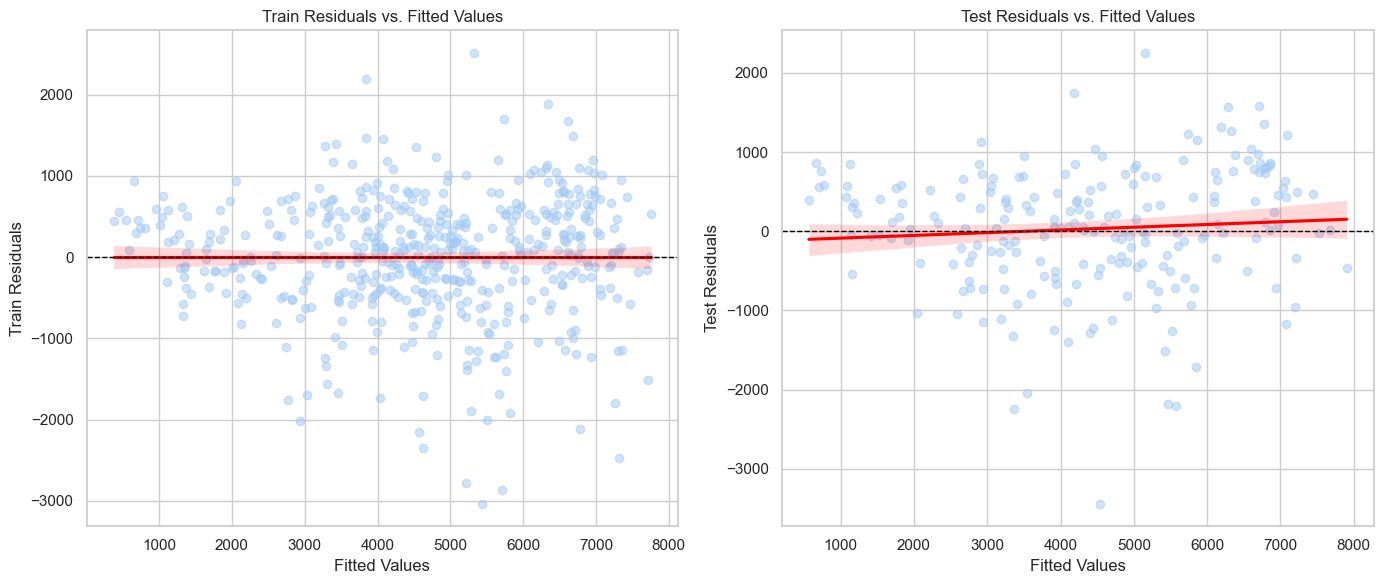

In [68]:
# Plot residuals vs. fitted values with regression lines
plt.figure(figsize=(14, 6))

# Train residuals
plt.subplot(1, 2, 1)
sns.regplot(x=y_train_pred, y=train_residuals, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Fitted Values')
plt.ylabel('Train Residuals')
plt.title('Train Residuals vs. Fitted Values')

# Test residuals
plt.subplot(1, 2, 2)
sns.regplot(x=y_test_pred, y=test_residuals, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Fitted Values')
plt.ylabel('Test Residuals')
plt.title('Test Residuals vs. Fitted Values')

plt.tight_layout()
plt.show()

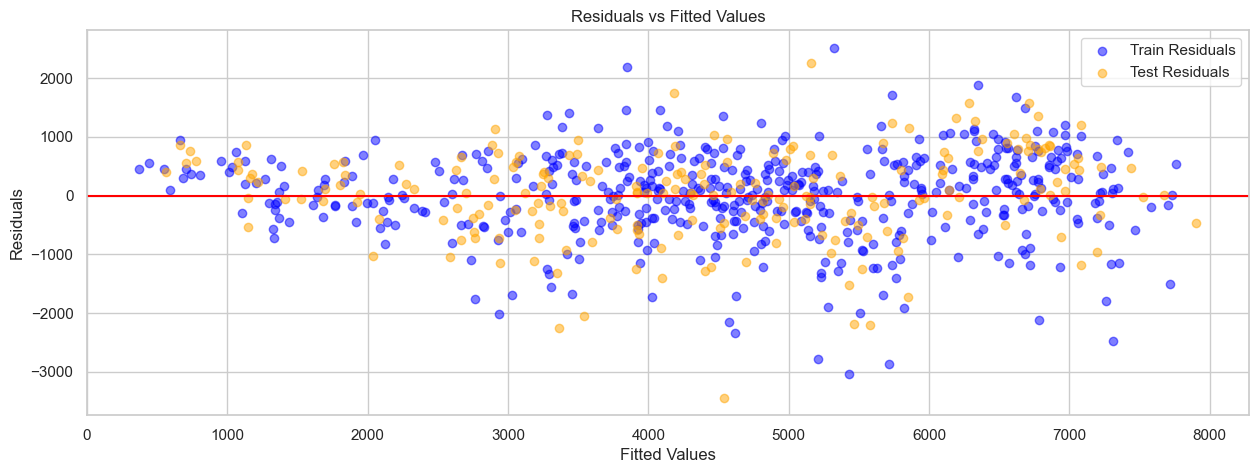

In [69]:
# Create a single figure for residuals
plt.figure(figsize=(15, 5))

# Scatter plot of residuals for the training set
plt.scatter(y_train_pred, train_residuals, alpha=0.5, label='Train Residuals', color='blue')
plt.scatter(y_test_pred, test_residuals, alpha=0.5, label='Test Residuals', color='orange')
plt.axhline(y=0, color='red', linestyle='-')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

#### Testing for `linearity`, `homoscedasticity` and `normality of residuals`

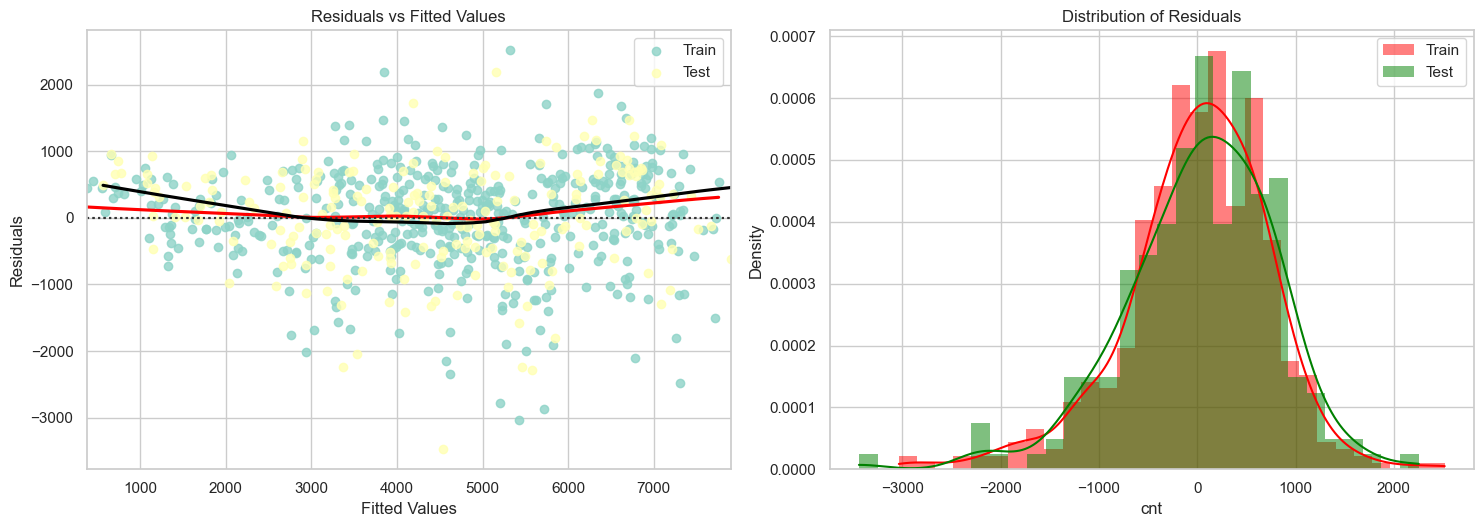

In [70]:
# Set a color theme
sns.set_palette("Set3")

plt.figure(figsize=(15, 10))

# Residuals vs Fitted Values for Train and Test
plt.subplot(2, 2, 1)
sns.residplot(x=y_train_pred, y=train_residuals, lowess=True, line_kws={'color': 'red'}, label='Train')
sns.residplot(x=y_test_pred, y=test_residuals, lowess=True, line_kws={'color': 'black'}, label='Test')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

# Distribution of Residuals for Train and Test
plt.subplot(2, 2, 2)
sns.histplot(train_residuals, bins=30, kde=True, color='red', label='Train', stat="density", linewidth=0)
sns.histplot(test_residuals, bins=30, kde=True, color='green', label='Test', stat="density", linewidth=0)
plt.title('Distribution of Residuals')
plt.legend()

plt.tight_layout()
plt.show()

#### Evaluation Conclusion

**Linearity, homoscedasticity, and normality of residuals**

- The residuals vs. fitted values plots for both training and test sets show that the residuals are randomly scattered around the horizontal line, indicating no clear patterns and `suggesting that the model's assumptions of linearity and homoscedasticity are reasonably met`.

- The `slight upward trend in the test residuals plot suggests a minor issue with the model underestimating higher values`. However, overall, the model's residuals do not exhibit strong patterns, which supports the validity of the linear regression model.

- The distribution of residuals plot shows that the residuals follow a roughly `normal distribution`, further `validating the assumptions of the linear regression model`.

Visual verify for accuracy of model

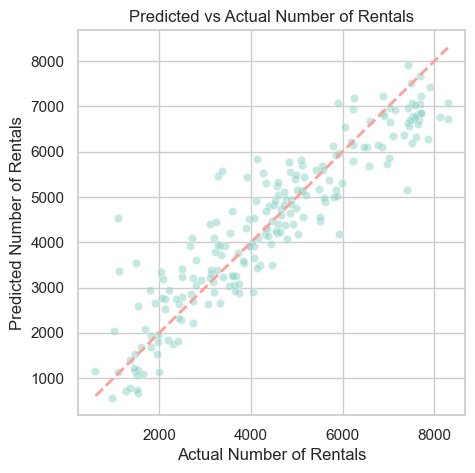

In [71]:
# Visual verify for accuracy of model
plt.figure(figsize=[5,5])
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('Predicted vs Actual Number of Rentals')
plt.xlabel('Actual Number of Rentals')
plt.ylabel('Predicted Number of Rentals')
plt.grid(True)
plt.show()

The plot visually confirms that the model captures the general trend in the data but may need refinement to enhance precision.

#### Q-Q plots

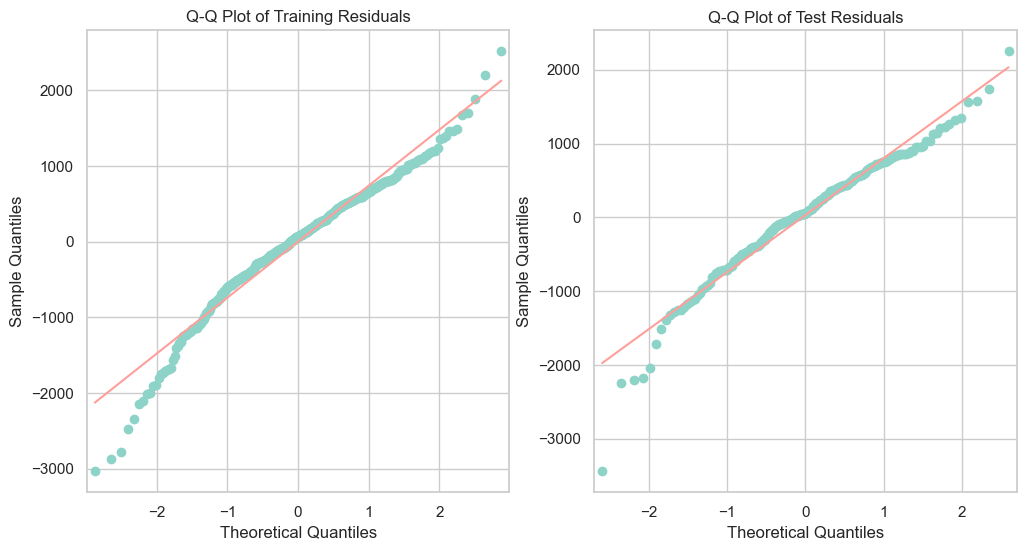

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Q-Q plot for training residuals
sm.qqplot(train_residuals, line='s', ax=axes[0])
axes[0].set_title('Q-Q Plot of Training Residuals')

# Q-Q plot for test residuals
sm.qqplot(test_residuals, line='s', ax=axes[1])
axes[1].set_title('Q-Q Plot of Test Residuals')

plt.show()

The Q-Q plots show that the residuals from both the training and test datasets closely follow the diagonal line, indicating that the residuals are approximately normally distributed. This supports the assumption of normality in the linear regression model.

In [73]:
# import scipy.stats as stats

# # Set a seaborn style
# # sns.set_theme(style="whitegrid")

# # Q-Q plot for train residuals
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# stats.probplot(train_residuals, dist="norm", plot=plt)
# plt.title('Q-Q Plot of Train Residuals')

# # Q-Q plot for test residuals
# plt.subplot(1, 2, 2)
# stats.probplot(test_residuals, dist="norm", plot=plt)
# plt.title('Q-Q Plot of Test Residuals')

# plt.tight_layout()
# plt.show()

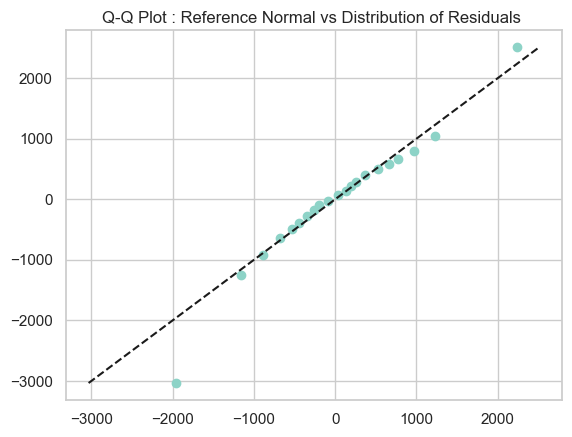

In [74]:
# Code copied from https://jayantb1019.github.io/

mean = (y_train-y_train_pred).mean()
std = (y_train-y_train_pred).std()

ref_normal = np.random.normal(mean,std,(y_train-y_train_pred).shape[0])

percs = np.linspace(0,100,21)
qn_ref_normal = np.percentile(ref_normal, percs)
qn_residual = np.percentile(y_train - y_train_pred , percs)

plt.plot(qn_ref_normal,qn_residual, ls="", marker="o")

x = np.linspace(np.min((qn_ref_normal.min(),qn_residual.min())), np.max((qn_ref_normal.max(),qn_residual.max())))
plt.plot(x,x, color="k", ls="--")
plt.title('Q-Q Plot : Reference Normal vs Distribution of Residuals ')
plt.show()

#### Line plots to compare actuals vs predications

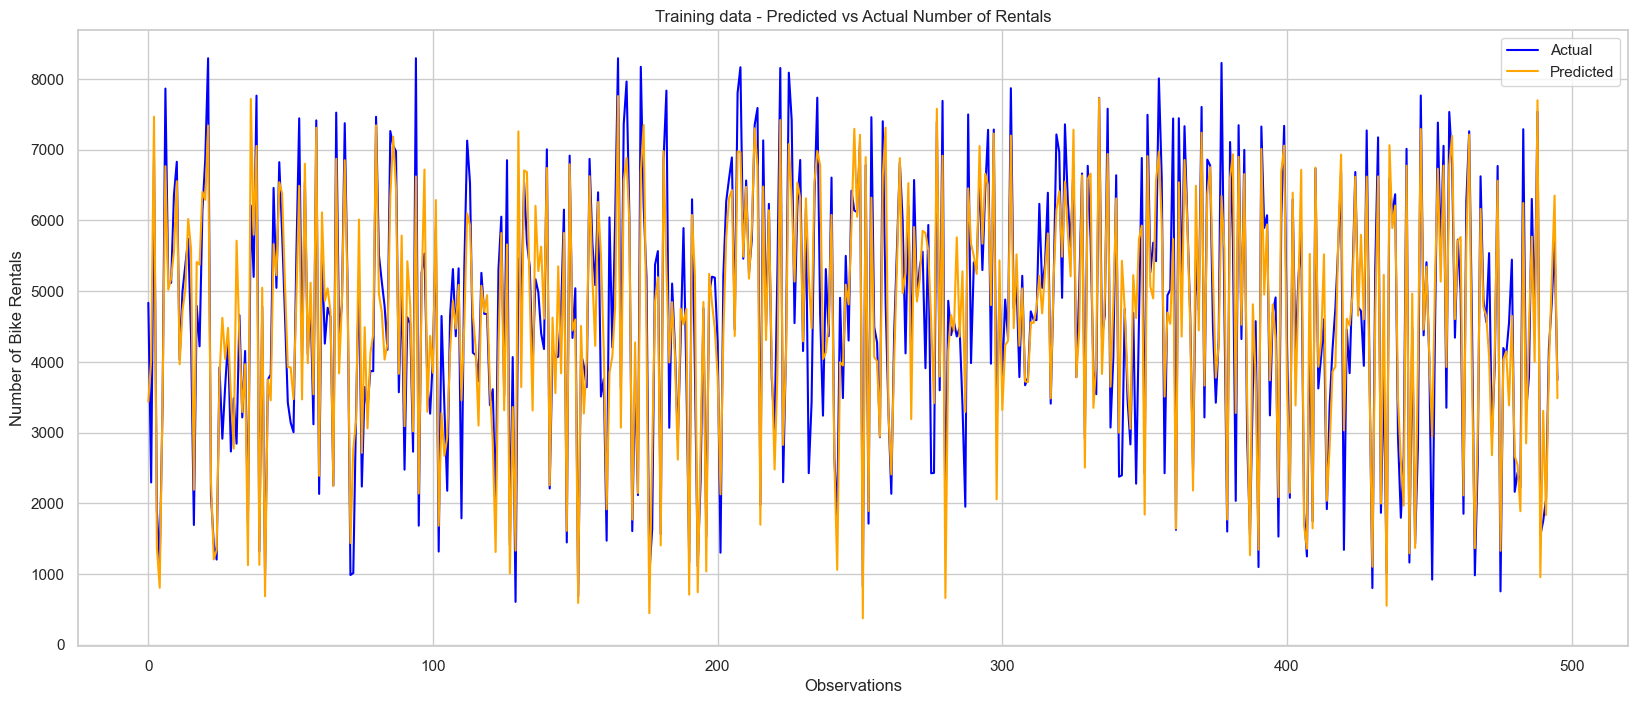

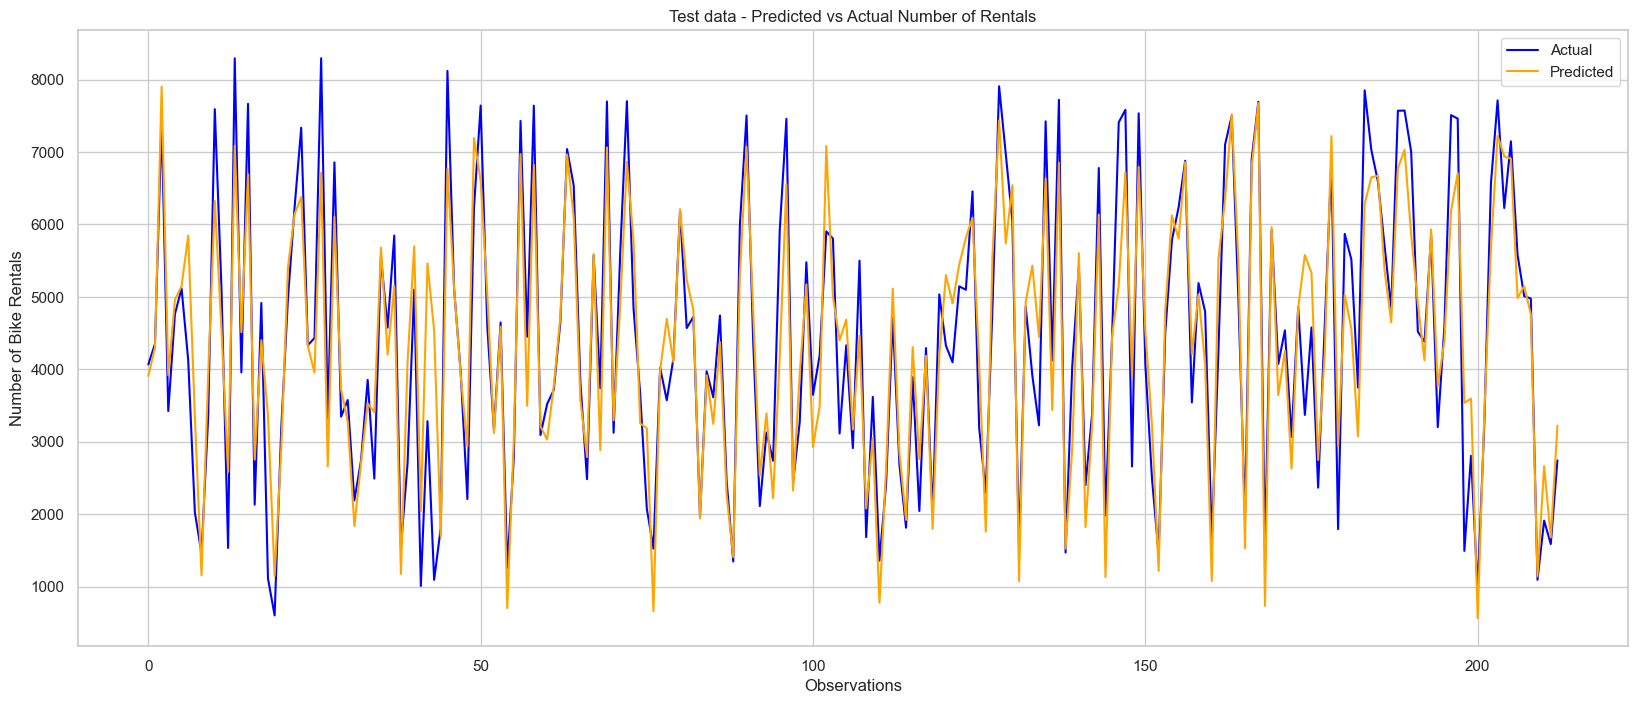

In [75]:
# Predicted vs. Actual Number of Rentals for Training and Test Data

plt.figure(figsize=(20, 8))
plt.plot(y_train.values, label='Actual', color='blue')
plt.plot(y_train_pred, label='Predicted', color='orange')
plt.title('Training data - Predicted vs Actual Number of Rentals')
plt.xlabel('Observations')
plt.ylabel('Number of Bike Rentals')
plt.legend()
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='orange')
plt.title('Test data - Predicted vs Actual Number of Rentals')
plt.xlabel('Observations')
plt.ylabel('Number of Bike Rentals')
plt.legend()
plt.show()

The plots for both training and test data show that the predicted values closely follow the actual number of bike rentals. While there are some deviations, the model captures the overall trend and variability of the bike rental demand effectively in both datasets, indicating a good fit.

In this final evaluation step, I assessed the performance of the refined linear regression model after handling multicollinearity and iteratively removing variables based on p-values. Here is the summary:

1. **Model Performance Metrics**:
   - **Training RMSE**: 739.443
   - **Testing RMSE**: 771.748
   - **Training R square**: 0.841
   - **Testing R square**: 0.846
   - **Training MAE**: 556.474
   - **Testing MAE**: 587.492

The final model shows strong performance, with R squared values indicating that it explains 84.1% of the variance in the training set and 84.6% in the testing set. The RMSE and MAE values are consistent across training and testing datasets, suggesting the model generalizes well without significant overfitting.

2. **Residual Analysis**:
   - **Residuals Over Observations**: The residuals are evenly distributed around zero with no clear pattern, indicating a good fit.
   - **Residuals vs. Fitted Values**: The residuals show no obvious pattern, suggesting that the model assumptions of linearity and homoscedasticity are reasonably met.
   - **Distribution of Residuals**: The residuals exhibit a slight negative skew and heavier tails than a normal distribution, indicating the presence of some outliers.

3. **Comparison with Earlier Models**:
   - **Initial Model**:
     - **Training RMSE**: 699.273, **Testing RMSE**: 754.254
     - **Training R square**: 0.858, **Testing R square**: 0.854
   - **Interim Model** (after initial variable removal):
     - **Training RMSE**: 739.443, **Testing RMSE**: 771.748
     - **Training R square**: 0.841, **Testing R square**: 0.846

Compared to earlier models, the final model has slightly higher RMSE values but maintains strong R squared values, indicating a good balance between model complexity and predictive power. The marginal increase in RMSE suggests that the model's robustness has improved by handling multicollinearity and focusing on significant predictors.

4. **Graphical Analysis**:
   - The plots of actual vs. predicted values for both training and testing datasets show a good alignment, confirming the model's predictive accuracy.
   - The residuals' plots reinforce that the model assumptions are met, with no significant patterns or heteroscedasticity observed.

Conclusion

- The final model, after addressing multicollinearity and removing insignificant variables, demonstrates strong predictive performance with consistent metrics across training and testing datasets. The residuals analysis supports the validity of the model assumptions, and the comparison with interim models shows a well-balanced and robust model. No further steps are necessary for model evaluation, and the focus can now shift to documenting and presenting the findings.

### 8. **Model Interpretation**

**Coefficients**: 

The final model includes several predictor variables that significantly impact bike demand (`cnt`):

- **Year (`yr`)**: Demand in 2019 is higher by 1929 units compared to 2018, indicating an increasing trend.
- **Working Day (`workingday`)**: On working days, bike demand increases by 366 units, likely due to commuting patterns.
- **Temperature (`temp`)**: For every unit increase in temperature, demand increases by 4164 units, showing a strong positive relationship.
- **Humidity (`hum`)**: A one-unit increase in humidity decreases demand by 1197 units, likely due to discomfort.
- **Wind Speed (`windspeed`)**: Higher wind speeds reduce demand by 1079 units.
- **Seasons**: Summer and winter see increased demands by 806 and 1082 units respectively, compared to spring.
- **Months**: Demand is higher in March (375 units), August (649 units), September (1061 units), and October (460 units) compared to January.
- **Weekday (`weekday_Saturday`)**: Demand on Saturdays is higher by 395 units compared to Sundays.
- **Weather Situation (`weathersit_mist/cloud`)**: Misty or cloudy weather decreases demand by 450 units.
- **Temperature Range (`temp_range_Medium`)**: Medium temperature ranges increase demand by 336 units.

**Conclusion**:
The final model highlights key factors affecting bike demand. Insights from variables such as temperature, year, working days, and specific months and seasons can help BoomBikes strategize to better meet customer demand and increase revenue post-pandemic.

### 9. **Hypothesis Testing**

- `Null Hypothesis (H0)`: there is no relationship between the predictor variable and the dependent variable.

- `Alternative Hypothesis (H1)`: there is a significant relationship between the predictor variable and the dependent variable.


In [76]:
# Ref : https://www.sciencedirect.com/topics/mathematics/f-statistics

# Calculate Mean Squared Error (MSE) for residuals
MSE = np.mean(train_residuals**2)

# Calculate Mean Squared Regression (MSR)
MSR = np.mean((y_train_pred - np.mean(y_train))**2)

# Calculate F-statistic
F = MSR / MSE

print(f"F-statistic: {F}")

# Calculate p-value for F-statistic using F-distribution
from scipy.stats import f

# degrees of freedom for the numerator (number of predictors)
df_numerator = X.shape[1] - 1

# degrees of freedom for the denominator (number of observations - number of predictors - 1)
df_denominator = len(y_train) - X.shape[1]

p_value_f = 1 - f.cdf(F, df_numerator, df_denominator)
print(f"p-value (F-test): {p_value_f}")


F-statistic: 5.278767086795755
p-value (F-test): 1.1102230246251565e-16


**Based on the F-statistic of 5.28 and a p-value of almost zero, `I reject the null hypothesis`, indicating that my linear regression model significantly explains the variability in bike demand.**

In [77]:
train_residual_mean = (y_train - y_train_pred).mean()
test_residual_mean = (y_test - y_test_pred).mean()

print(f"Mean of training residuals: {round(train_residual_mean, 5)}")
print(f"Mean of test residuals: {round(test_residual_mean, 5)}")

Mean of training residuals: -0.0
Mean of test residuals: 30.1492


**Model fits well with training data but underestimates by ~30 unites for test data.**

### 10. **Conclusions and Recommendations**

**Conclusion and Recommendations**

The linear regression model developed to predict bike demand performs well covering significant portion of data, showing no significant bias, but slightly underestimates the demand on the test data. Key predictors are  temperature, year, working days, and specific months and seasons. 

Although the residuals are randomly scattered, indicating that the assumptions of linearity and homoscedasticity are reasonably met, the slight underestimation in the test set suggests there is room for improvement.

**Recommendations**

1. **Model Refinement**: Further refine the model by exploring more complex algorithms, such as random forests or gradient boosting, to capture potential non-linear relationships and interactions between ion in the test set.
2. **Regularization**: Apply regularization techniques, such as Lasso or Ridge regression, to prevent overfitting and improve the model's generalization to unseen data.
3. **Data Collection**: Enhance data collection efforts to include additional relevant variables, such as exact dates, bike station locations, and capacity, to provide a more comprehensive understanding of factors affecting bike demand.
4. **Variable Pricing Strategy**: Implement a variable pricing strategy based on the identified key predictors, such as offering discounts on low-demand days (e.g., high humidity, high wind speeds) and increasing prices during peak demand periods (e.g., summer, weekends), to optimize revenue and better manage bike availability.

By implementing these recommendations, BoomBikes can enhance their predictive modeling capabilities and better prepare for post-pandemic demand, ultimately leading to increased customer satisfaction and revenue.

### 11. **Assignment-based Subjective Questions**

#### Q.1 - From your analysis of the categorical variables, what can you infer about their effect on the dependent variable? (3 marks)


From the analysis of categorical variables in the bike-sharing dataset, several key inferences can be made about their effect on the dependent variable (`cnt`):

1. **Year (`yr`)**: Bike demand in 2019 is significantly higher by 1928.80 units compared to 2018, indicating an increasing trend in rentals.

2. **Season (`season`)**: Summer and winter seasons show higher bike demand by 806.27 and 1082.12 units, respectively, compared to spring, suggesting more favorable conditions or increased activities in these seasons.

3. **Month (`mnth`)**: Specific months such as March, August, September, and October have higher demand by 375.02, 649.41, 1060.85, and 460.11 units, respectively, compared to January, reflecting seasonal trends.

4. **Weekday (`weekday`)**: Saturdays have higher bike demand by 395.07 units compared to Sundays, likely due to leisure activities on weekends.

5. **Working Day (`workingday`)**: Higher bike demand on working days by 366.10 units suggests commuting patterns drive rentals.

6. **Weather Situation (`weathersit`)**: Misty or cloudy weather decreases bike demand by 450.38 units compared to clear weather, indicating that adverse conditions deter bike usage.

#### Q.2 - Why is it important to use drop_first=True during dummy variable creation? (2 mark)

Using `drop_first=True` during dummy variable creation is important to avoid multicollinearity, which occurs when independent variables in a regression model are highly correlated. Multicollinearity can lead to difficulties in estimating the regression coefficients accurately and can inflate the variance of the coefficient estimates, making the model less reliable. By dropping the first category, we avoid the "dummy variable trap," ensuring that there is no redundancy among the dummy variables and the regression model remains well-defined and interpretable.

Here is typical code which implements drop_first when creating dummy variables using Pandas

```python
data = pd.get_dummies(data, columns=categorical_vars, drop_first=True)


#### Q.3 - Looking at the pair-plot among the numerical variables, which one has the highest correlation with the target variable? (1 mark)

Looking at pair plot variable `registered` has the highest correlation with `cnt`. 

`Cnt` is sum of `casual` and `registered` and `registered` has larger share in `cnt`, so this correlation is expected. However if I ignore `casual` and `registered`, variables `temp` and `atemp` have the highest correlation with `cnt`

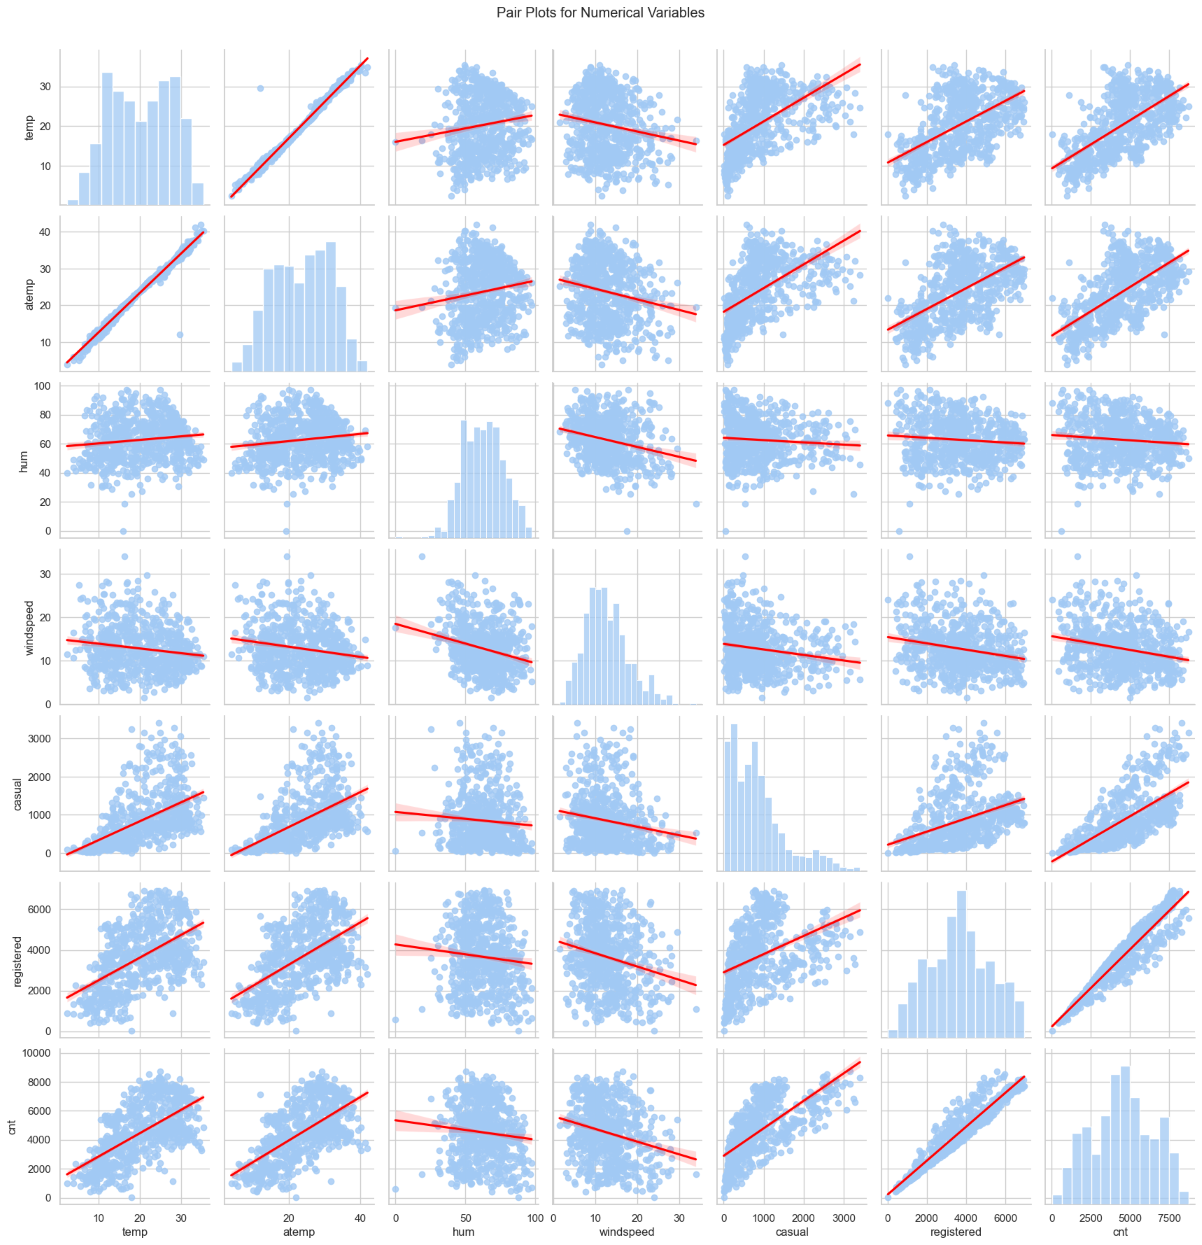

#### Q.4 - How did you validate the assumptions of Linear Regression after building the model on the training set? (3 marks)

To validate the assumptions of Linear Regression after building the model on the training set, the following checks were performed:

1. **Linearity and Homoscedasticity**: Residuals vs. fitted values plots for both training and test sets show that residuals are randomly scattered around the horizontal line, indicating no clear patterns. This suggests that the model's assumptions of linearity and homoscedasticity are reasonably met.

2. **Normality of Residuals**: Q-Q plots for both training and test residuals show that the residuals mostly follow the straight line, indicating that they are approximately normally distributed.

3. **Independence of Residuals**: The Durbin-Watson statistic of 2.02 suggests that there is no significant autocorrelation in the residuals.

4. **Multicollinearity**: Evaluated the VIF (Variance Inflation Factor) to ensure no predictor variables exhibited high multicollinearity.

5. The OLS summary was used to ensure all predictors are significant with very low p-values (< 0.05).

6. The model's performance metrics indicate strong predictive power with an Adjusted R Squared of 0.836, RMSE values of 739.44 (train) and 771.75 (test), and MAE values of 556.47 (train) and 587.49 (test), demonstrating consistent performance across both training and test datasets.

   - Training set R Squared: 0.84
   - Test set R Squared: 0.85
   - Adjusted R Squared: 0.836
   - RMSE values: 739.443 (train), 771.748 (test)
   - MAE values: 556.47 (train), 587.49 (test)



#### Q.5 - Based on the final model, which are the top 3 features contributing significantly towards explaining the demand of the shared bikes? (2 marks)

Based on the final model, the top 3 features contributing significantly towards explaining the demand for shared bikes are:

1. Temperature (`temp`) with a coefficient of 4164.17.
2. Year (`yr`) with a coefficient of 1928.80.
3. Humidity (`hum`) with a coefficient of -1197.26.

Winter season (1082.12) and wind speed (-1079.39) are righ next to humdidity in terms of impact. 

### 12. General Subjective Questions

#### Q.1 - Explain the linear regression algorithm in detail. (4 marks)

Linear regression is a supervised learning algorithm used to predict a continuous target variable based on one or more predictor variables. 

The relationship between the target variable $y$ and the predictor variables $X$ is modeled by a linear equation:

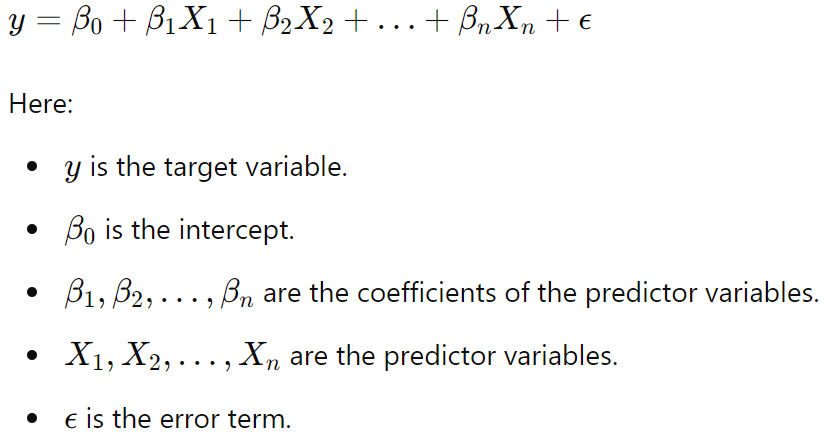

The goal of linear regression is to find the values of $\beta$ (coefficients) that minimize the sum of squared residuals (the differences between the observed and predicted values). This is often achieved using the Ordinary Least Squares (OLS) method. The main steps involved are:
1. **Calculate the predicted values** using the initial or given coefficients.
2. **Compute the residuals** by subtracting the predicted values from the observed values.
3. **Minimize the sum of squared residuals** to find the best-fit line.

**Advantages of Linear Regression Models**

1. **Simplicity**: Easy to understand and implement.
2. **Interpretability**: Coefficients provide insights into the relationship between variables.
3. **Efficiency**: Computationally efficient for training and predictions.
4. **Scalability**: Can handle large datasets with linear complexity.
5. **Assumptions**: Works well if the relationship between the dependent and independent variables is approximately linear.

**Disadvantages of Linear Regression Models**

1. **Linearity Assumption**: Assumes a linear relationship, which might not hold true for all datasets.
2. **Outliers**: Sensitive to outliers, which can disproportionately affect the model.
3. **Multicollinearity**: Highly correlated independent variables can lead to unstable estimates.
4. **Homogeneity of Variance**: Assumes constant variance of errors, which might not be the case (heteroscedasticity).
5. **Limited Complexity**: Struggles with capturing complex relationships in the data.

#### Q.2 - Explain Anscombe’s quartet in detail. (3 marks)

Ref : https://en.wikipedia.org/wiki/Anscombe%27s_quartet

Anscombe’s quartet comprises four datasets that have nearly identical simple descriptive statistics, yet appear very different when graphed. Each dataset has the same mean, variance, correlation, and linear regression line. `The quartet demonstrates the importance of graphing data before analyzing it and the potential for statistics to mislead without visual inspection`. 

The four datasets as shown in image below:
1. Dataset I - A typical linear relationship.
2. Dataset II - A dataset where the relationship is nonlinear.
3. Dataset III - A dataset with an outlier that influences the regression line.
4. Dataset IV - A dataset where the x-values are all the same except one outlier.

    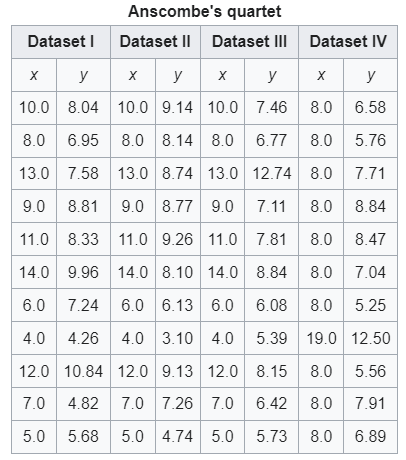

The four datasets have nearly identical simple descriptive statistics

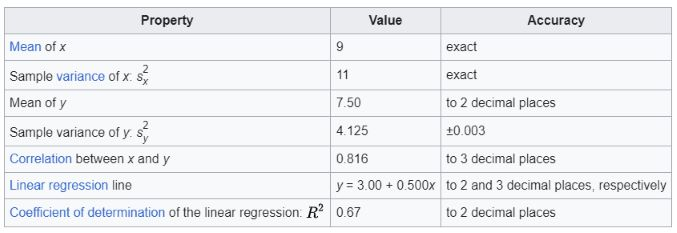

But when plotted each dataset show different story.

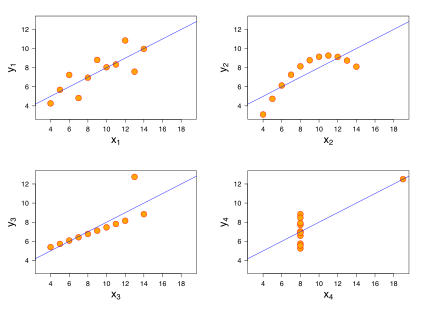

#### Q.3 - What is Pearson’s R? (3 marks)

Ref : https://www.scribbr.com/statistics/pearson-correlation-coefficient/

Named after its inventor Karl Perason, Pearson's R, also known as the Pearson correlation coefficient, measures the linear correlation between two variables. It ranges from -1 to +1, where:
- +1 indicates a perfect positive linear relationship.
- -1 indicates a perfect negative linear relationship.
- 0 indicates no linear relationship.

    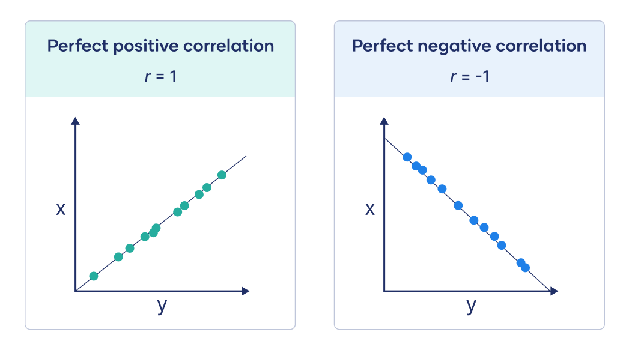

    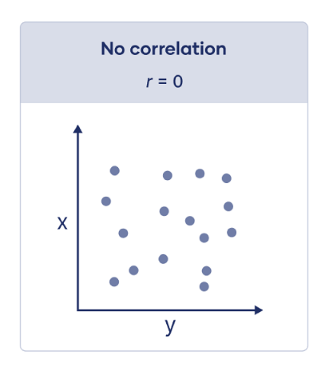

#### Q.4 - What is scaling? Why is scaling performed? What is the difference between normalized scaling and standardized scaling? (3 marks)


Ref : https://www.shiksha.com/online-courses/articles/normalization-and-standardization/

**Scaling** is the process of transforming the features of a dataset so that they have a similar scale, which can improve the performance and convergence of machine learning algorithms. 

While these terms are often used interchangeably, they serve different purposes and contexts.

**Why Scaling is Performed**:
- **Improves model performance**: Algorithms like gradient descent converge faster with scaled features.
- **Prevents dominance**: Features with larger ranges can dominate the learning process, leading to biased models.
- **Standardizes input**: Ensures that each feature contributes equally to the model.

**Differences between Normalized and Standardized Scaling**:
- **Normalization**: 
    - **Defination**: Scales data to a fixed range, typically 0 to 1. 
    - **Objective**: To change the scale of the variables so that they fit within a specific range.
    - **When**: Use normalization when algorithms assume input features are on a similar scale or bounded range, such as neural networks, or to speed up gradient descent convergence, especially if data doesn't follow a Gaussian distribution or for models like k-nearest neighbors where variable magnitude is important.
    - **Formula**: 

        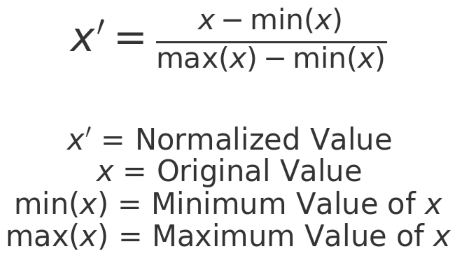

- **Standardization**: 
    - **Defination**: Transforms data to have a mean of 0 and a standard deviation of 1. 
    - **Objective**: To change the distribution of the variables to a standard normal distribution.
    - **When**: Use standardization when algorithms assume input features are normally distributed with zero mean and unit variance, such as Support Vector Machines and Logistic Regression, or to handle outliers effectively.
    - **Formula**:

        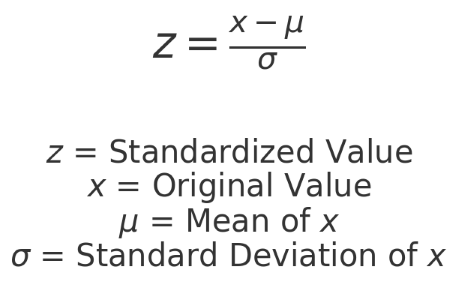

- Here is typical graph of normalized vs standardized data
    - 
    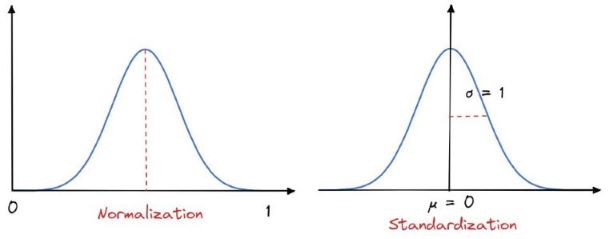

#### Q.5 - You might have observed that sometimes the value of VIF is infinite. Why does this happen? (3 marks)

Ref : https://www.sigmamagic.com/blogs/what-is-variance-inflation-factor/

VIF (Variance Inflation Factor) measures the degree of multicollinearity among predictor variables in a regression model. An infinite VIF occurs when there is perfect multicollinearity, meaning that one predictor variable is a perfect linear combination of one or more other predictors. This situation makes it impossible to estimate the coefficients uniquely, leading to an infinite VIF.

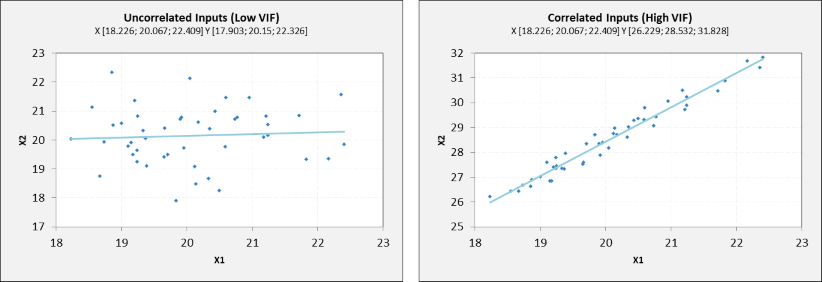


#### Q.6 - What is a Q-Q plot? Explain the use and importance of a Q-Q plot in linear regression. (3 marks)

A Q-Q (Quantile-Quantile) plot is a graphical tool used to assess whether a dataset follows a given distribution, typically the normal distribution. It plots the quantiles of the sample data against the quantiles of a theoretical distribution. If the data follows the theoretical distribution, the points should form an approximate straight line.

**Use and Importance in Linear Regression**:
- **Normality Check**: It helps in checking the normality of residuals. Normally distributed residuals are an assumption of linear regression.
- **Identifying Outliers**: Deviations from the straight line indicate departures from normality, such as skewness or outliers.
- **Model Validation**: Ensures that the residuals meet the assumptions of the linear regression model, validating the model's reliability.

Q-Q plot used during model evaluation for Bike sharing assignment.

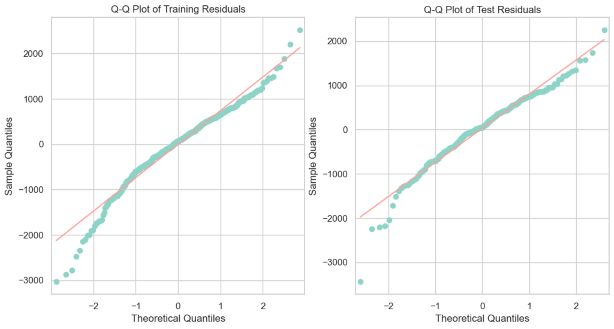